### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- try using google / model swap
- rate on various dimensions
- when doing summary, store the log length of the text for the summary
- store rating by source, bloomberg is high, normal pubs, prob garbage

spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [16]:
# to selectively re-import as needed
import sys
del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
del sys.modules['AInewsbot_langgraph']



In [17]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [18]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
before_date = '2025-02-22 15:00'
do_download = True

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
# try google anthropic
# pass a parameter - model_low, model_medium, model_high , 
# make a function get_model, map string to google , openai, claude
# get_model maps input, calls chatopenai, chatgoogle, chatanthropic with the model string

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
display(Markdown(state['summary'].replace("$", "\\\\$")))

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-02-26 12:41:45,432 - AInewsbot - INFO - Initializing with before_date=2025-02-26 08:00, do_download=True, thread_id=cd47545231d54e7f9baaf160d7777f42


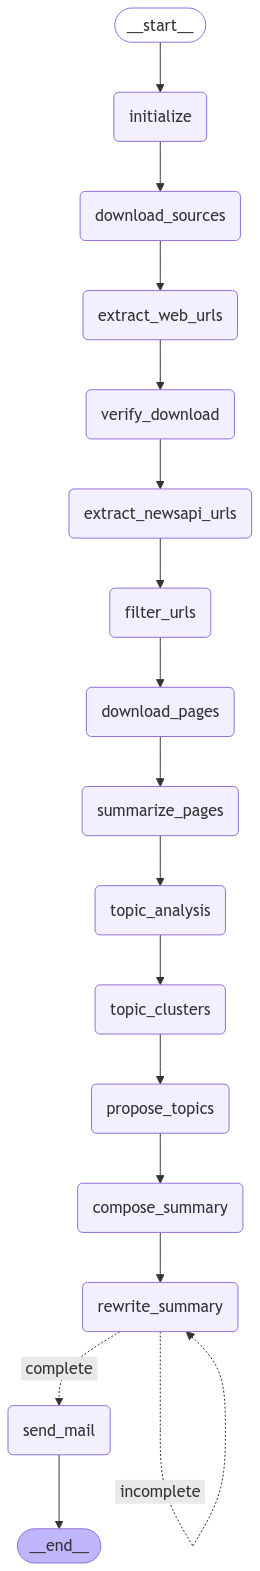

In [19]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-26 08:00'
do_download = True
ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro', 'models/gemini-2.0-flash-thinking-exp'
state, lg_agent, thread_id = initialize_agent(do_download, before_date, ml, mm, mh)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [20]:
state = lg_agent.initialize(state)


2025-02-26 12:41:47,562 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-26 12:41:47,563 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-26 12:41:47,563 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-26 12:41:47,564 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-26 12:41:47,564 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-26 12:41:47,564 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-26 12:41:47,565 - AInewsbot - INFO - 

In [21]:
state = lg_agent.download_sources(state)


2025-02-26 12:41:49,077 - AInewsbot - INFO - Saving HTML files using 4 browsers
2025-02-26 12:43:01,810 - AInewsbot - INFO - Processing Ars Technica
2025-02-26 12:43:01,811 - AInewsbot - INFO - Processing Bloomberg Tech
2025-02-26 12:43:01,811 - AInewsbot - INFO - Processing Business Insider
2025-02-26 12:43:01,812 - AInewsbot - INFO - Processing FT Tech
2025-02-26 12:43:01,813 - AInewsbot - INFO - get_file(Ars Technica) - starting get_file https://arstechnica.com/
2025-02-26 12:43:01,813 - AInewsbot - INFO - get_file(Bloomberg Technology) - starting get_file https://www.bloomberg.com/ai
2025-02-26 12:43:01,814 - AInewsbot - INFO - get_file(Business Insider Tech) - starting get_file https://www.businessinsider.com/tech
2025-02-26 12:43:01,815 - AInewsbot - INFO - get_file(FT Technology) - starting get_file https://www.ft.com/technology
2025-02-26 12:43:12,149 - AInewsbot - INFO - get_file(Business Insider Tech) - Saving Business Insider Tech (02_26_2025 12_43_12 PM).html as UTF-8
2025-

2025-02-26 12:44:32,805 - AInewsbot - INFO - Downloaded Reddit to htmldata/Reddit multiple subreddits (02_26_2025 12_43_56 PM).html
2025-02-26 12:44:32,805 - AInewsbot - INFO - Downloaded WaPo Tech to htmldata/Washington Post Technology (02_26_2025 12_44_11 PM).html
2025-02-26 12:44:32,806 - AInewsbot - INFO - Downloaded Business Insider to htmldata/Business Insider Tech (02_26_2025 12_43_12 PM).html
2025-02-26 12:44:32,806 - AInewsbot - INFO - Downloaded Feedly AI to htmldata/Feedly AI (02_26_2025 12_44_32 PM).html
2025-02-26 12:44:32,806 - AInewsbot - INFO - Saved 16 HTML files


In [22]:
state = lg_agent.extract_web_urls(state)


2025-02-26 12:45:34,620 - AInewsbot - INFO - Parsing html files
2025-02-26 12:45:34,621 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (02_26_2025 12_43_14 PM).html
2025-02-26 12:45:34,682 - AInewsbot - INFO - parse_file - found 204 raw links
2025-02-26 12:45:34,690 - AInewsbot - INFO - parse_file - found 39 filtered links
2025-02-26 12:45:34,691 - AInewsbot - INFO - 39 links found
2025-02-26 12:45:34,691 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (02_26_2025 12_43_22 PM).html
2025-02-26 12:45:34,712 - AInewsbot - INFO - parse_file - found 204 raw links
2025-02-26 12:45:34,715 - AInewsbot - INFO - parse_file - found 16 filtered links
2025-02-26 12:45:34,715 - AInewsbot - INFO - 16 links found
2025-02-26 12:45:34,715 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (02_26_2025 12_43_12 PM).html
2025-02-26 12:45:34,736 - AInewsbot - INFO - parse_file - found 207 raw links
2025-02-26 12:45:34,739 - AInewsbot - INFO - parse_file 

In [23]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,30
Bloomberg Tech,12
Business Insider,21
FT Tech,62
Feedly AI,30
Hacker News,27
Hacker News 2,19
HackerNoon,101
NYT Tech,18


number of missing sources 0


set()

In [24]:
state = lg_agent.verify_download(state)


2025-02-26 12:45:38,194 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [25]:
state = lg_agent.extract_newsapi_urls(state)


2025-02-26 12:45:40,705 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-02-25T12:45:40 from NewsAPI


In [26]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


2025-02-26 12:45:42,173 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-02-26 08:00'
2025-02-26 12:45:42,696 - AInewsbot - INFO - URLs in orig_df: 905
2025-02-26 12:45:42,700 - AInewsbot - INFO - Existing URLs in DB: 222446
2025-02-26 12:45:42,760 - AInewsbot - INFO - New URLs in df filtered by URL: 371
2025-02-26 12:45:42,885 - AInewsbot - INFO - Existing src+title: 23
2025-02-26 12:45:42,886 - AInewsbot - INFO - New URLs in df filtered by src+title: 348
2025-02-26 12:45:42,899 - AInewsbot - INFO - Found 348 unique new headlines
2025-02-26 12:45:42,903 - AInewsbot - INFO - Found 344 unique cleaned new headlines
2025-02-26 12:45:49,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:45:50,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:45:50,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,3
Bloomberg Tech,3
Business Insider,6
FT Tech,5
Feedly AI,25
Hacker News,2
Hacker News 2,5
HackerNoon,10
NYT Tech,1


In [27]:
state = lg_agent.download_pages(state)


2025-02-26 12:45:58,444 - AInewsbot - INFO - Queuing URLs for scraping
2025-02-26 12:45:58,447 - AInewsbot - INFO - Processing page 0: https://gizmodo.com/does-our-code-kill-kids-microsoft-employees-protest-selling-ai-to-israel-2000568642
2025-02-26 12:45:58,448 - AInewsbot - INFO - Processing page 1: https://www.ghacks.net/2025/02/25/1000-artists-release-silent-album-to-protest-uk-copyright-changes-favoring-ai/
2025-02-26 12:45:58,448 - AInewsbot - INFO - Processing page 2: https://www.geeky-gadgets.com/human-skills-ai-cannot-replace/
2025-02-26 12:45:58,448 - AInewsbot - INFO - Processing page 3: https://www.coindesk.com/opinion/2025/02/25/5-new-trends-in-generative-ai-that-web3-needs-to-be-ready-for
2025-02-26 12:45:58,448 - AInewsbot - INFO - get_url(https://gizmodo.com/does-our-code-kill-kids-microsoft-employees-protest-selling-ai-to-israel-2000568642) - starting get_url https://gizmodo.com/does-our-code-kill-kids-microsoft-employees-protest-selling-ai-to-israel-2000568642
2025-02

2025-02-26 12:46:04,775 - AInewsbot - INFO - get_url(A survey of US workers in October 2024: 52% are worried about AI's workplace impact, 32% think it will mean fewer job opportunities, 36% feel hopeful, and more) - Saving A_survey_of_US_workers_in_October_2024__52__are_worried_about_AI_s_workplace_impact__32__think_it_will_mean_fewer_job_opportunities__36__feel_hopeful__and_more.html as UTF-8
2025-02-26 12:46:04,776 - AInewsbot - INFO - Processing page 14: https://www.forbes.com/sites/garydrenik/2025/02/25/ai-is-changing-the-wealth-management-industry-forever/
2025-02-26 12:46:04,776 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/garydrenik/2025/02/25/ai-is-changing-the-wealth-management-industry-forever/) - starting get_url https://www.forbes.com/sites/garydrenik/2025/02/25/ai-is-changing-the-wealth-management-industry-forever/
2025-02-26 12:46:06,764 - AInewsbot - INFO - get_url(AI In Content Production: A Friend, Not Foe?) - Saving AI_In_Content_Production__A_Friend__Not

2025-02-26 12:46:16,058 - AInewsbot - INFO - get_url(Alibaba releases Wan 2.1, a family of open-source AI models for generating images and videos, available globally on Alibaba Cloud's ModelScope and Hugging Face) - Saving Alibaba_releases_Wan_2.1__a_family_of_open-source_AI_models_for_generating_images_and_videos__available_globally_on_Alibaba_Cloud_s_ModelScope_and_Hugging_Face.html as utf-8
2025-02-26 12:46:16,060 - AInewsbot - INFO - Processing page 27: https://www.bloomberg.com/news/articles/2025-02-26/amazon-unveils-long-awaited-ai-version-of-alexa-voice-assistant
2025-02-26 12:46:16,060 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-02-26/amazon-unveils-long-awaited-ai-version-of-alexa-voice-assistant) - starting get_url https://www.bloomberg.com/news/articles/2025-02-26/amazon-unveils-long-awaited-ai-version-of-alexa-voice-assistant
2025-02-26 12:46:16,795 - AInewsbot - INFO - get_url(Amazon Unveils Long-Awaited AI Version of Alexa Voice Assistant) - 

2025-02-26 12:46:22,311 - AInewsbot - INFO - get_url(AppLovin's stock falls 10%+ after two short sellers released reports questioning the integrity of the company's AI-powered AXON ad software (CJ Haddad/CNBC)) - Saving AppLovin_s_stock_falls_10___after_two_short_sellers_released_reports_questioning_the_integrity_of_the_company_s_AI-powered_AXON_ad_software__CJ_Haddad_CNBC.html as utf-8
2025-02-26 12:46:22,314 - AInewsbot - INFO - Processing page 40: https://www.wsj.com/tech/apple-pledges-to-fix-transcription-glitch-that-replaces-racist-with-trump-4f3e63e7
2025-02-26 12:46:22,314 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/apple-pledges-to-fix-transcription-glitch-that-replaces-racist-with-trump-4f3e63e7) - starting get_url https://www.wsj.com/tech/apple-pledges-to-fix-transcription-glitch-that-replaces-racist-with-trump-4f3e63e7
2025-02-26 12:46:23,128 - AInewsbot - INFO - get_url(Apple Pledges to Fix Transcription Glitch That Replaces Racist With Trump) - Saving Apple_Pledg

2025-02-26 12:46:30,465 - AInewsbot - INFO - Processing page 51: https://www.404media.co/bluesky-deletes-ai-protest-video-of-trump-sucking-musks-toes-calls-it-non-consensual-explicit-material/
2025-02-26 12:46:30,465 - AInewsbot - INFO - get_url(https://www.404media.co/bluesky-deletes-ai-protest-video-of-trump-sucking-musks-toes-calls-it-non-consensual-explicit-material/) - starting get_url https://www.404media.co/bluesky-deletes-ai-protest-video-of-trump-sucking-musks-toes-calls-it-non-consensual-explicit-material/
2025-02-26 12:46:31,001 - AInewsbot - INFO - get_url(Bang goes AI? DeepSeek and the Star Trek future) - Saving Bang_goes_AI__DeepSeek_and_the_Star_Trek_future.html as utf-8
2025-02-26 12:46:31,003 - AInewsbot - INFO - Processing page 52: https://techcrunch.com/2025/02/26/bridgetown-research-raises-19m-to-speed-up-due-diligence-with-ai/
2025-02-26 12:46:31,003 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/02/26/bridgetown-research-raises-19m-to-speed-up-due-dilige

2025-02-26 12:46:37,827 - AInewsbot - INFO - get_url(https://github.com/deepseek-ai/DeepGEMM) - starting get_url https://github.com/deepseek-ai/DeepGEMM
2025-02-26 12:46:37,840 - AInewsbot - INFO - get_url(DIAGNOS to File for FDA Pre-Market Authorization of Its AI-Powered CARA SYSTEM and Engages Ora as Regulatory Specialist) - Saving DIAGNOS_to_File_for_FDA_Pre-Market_Authorization_of_Its_AI-Powered_CARA_SYSTEM_and_Engages_Ora_as_Regulatory_Specialist.html as utf-8
2025-02-26 12:46:37,841 - AInewsbot - INFO - Processing page 66: https://biztoc.com/x/3897605ab3a5e835
2025-02-26 12:46:37,841 - AInewsbot - INFO - get_url(https://biztoc.com/x/3897605ab3a5e835) - starting get_url https://biztoc.com/x/3897605ab3a5e835
2025-02-26 12:46:38,158 - AInewsbot - INFO - get_url(DeepSeek Resumes Allowing AI Access Following Capacity Shortages) - Saving DeepSeek_Resumes_Allowing_AI_Access_Following_Capacity_Shortages.html as utf-8
2025-02-26 12:46:38,158 - AInewsbot - INFO - Processing page 67: https:

2025-02-26 12:46:43,254 - AInewsbot - INFO - Processing page 78: https://siliconangle.com/2025/02/26/f5-expands-application-security-new-platform-ai-powered-automation-tools/
2025-02-26 12:46:43,254 - AInewsbot - INFO - get_url(https://siliconangle.com/2025/02/26/f5-expands-application-security-new-platform-ai-powered-automation-tools/) - starting get_url https://siliconangle.com/2025/02/26/f5-expands-application-security-new-platform-ai-powered-automation-tools/
2025-02-26 12:46:43,979 - AInewsbot - INFO - get_url(European Parliament to grill Commission over ditched AI liability rules) - Saving European_Parliament_to_grill_Commission_over_ditched_AI_liability_rules.html as UTF-8
2025-02-26 12:46:43,980 - AInewsbot - INFO - Processing page 79: https://punchng.com/fg-unveils-ai-training-for-6000-teachers-nationwide/
2025-02-26 12:46:43,981 - AInewsbot - INFO - get_url(https://punchng.com/fg-unveils-ai-training-for-6000-teachers-nationwide/) - starting get_url https://punchng.com/fg-unve

2025-02-26 12:46:57,343 - AInewsbot - INFO - get_url(Graph Neural Networks for Image Similarity: An Alternative to Hashing?) - Saving Graph_Neural_Networks_for_Image_Similarity__An_Alternative_to_Hashing.html as utf-8
2025-02-26 12:46:57,345 - AInewsbot - INFO - Processing page 91: https://www.globenewswire.com/news-release/2025/02/25/3032233/28124/en/Healthcare-Cloud-User-Survey-Report-Q3-2024-Q1-2025-Artificial-Intelligence-Growth-and-the-Shift-to-Cloud-native-Applications-and-Edge-Computing.html
2025-02-26 12:46:57,345 - AInewsbot - INFO - get_url(https://www.globenewswire.com/news-release/2025/02/25/3032233/28124/en/Healthcare-Cloud-User-Survey-Report-Q3-2024-Q1-2025-Artificial-Intelligence-Growth-and-the-Shift-to-Cloud-native-Applications-and-Edge-Computing.html) - starting get_url https://www.globenewswire.com/news-release/2025/02/25/3032233/28124/en/Healthcare-Cloud-User-Survey-Report-Q3-2024-Q1-2025-Artificial-Intelligence-Growth-and-the-Shift-to-Cloud-native-Applications-and-E

2025-02-26 12:47:06,271 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-02-26/india-s-glance-deepens-pact-with-google-to-add-ai-content) - starting get_url https://www.bloomberg.com/news/articles/2025-02-26/india-s-glance-deepens-pact-with-google-to-add-ai-content
2025-02-26 12:47:06,560 - AInewsbot - INFO - get_url(IBM plans to acquire DataStax and its cloud database development platform to expand IBM's Watsonx AI portfolio; Crunchbase says DataStax has raised $342.6M) - Saving IBM_plans_to_acquire_DataStax_and_its_cloud_database_development_platform_to_expand_IBM_s_Watsonx_AI_portfolio__Crunchbase_says_DataStax_has_raised__342.6M.html as utf-8
2025-02-26 12:47:06,561 - AInewsbot - INFO - Processing page 103: https://venturebeat.com/games/john-gaetas-escape-ai-creates-platform-for-emerging-entertainment/
2025-02-26 12:47:06,561 - AInewsbot - INFO - get_url(https://venturebeat.com/games/john-gaetas-escape-ai-creates-platform-for-emerging-entertainment/) - star

2025-02-26 12:47:17,092 - AInewsbot - INFO - Processing page 115: https://www.talkandroid.com/501418-dimensity-7400-series/
2025-02-26 12:47:17,093 - AInewsbot - INFO - get_url(https://www.talkandroid.com/501418-dimensity-7400-series/) - starting get_url https://www.talkandroid.com/501418-dimensity-7400-series/
2025-02-26 12:47:18,215 - AInewsbot - INFO - get_url(New Dimensity 7400 Series Brings Flagship AI to Mid-Range Phones) - Saving New_Dimensity_7400_Series_Brings_Flagship_AI_to_Mid-Range_Phones.html as UTF-8
2025-02-26 12:47:18,216 - AInewsbot - INFO - Processing page 116: https://qz.com/nvidia-fiscal-q4-earnings-analysts-deepseek-ai-chips-1851766311
2025-02-26 12:47:18,217 - AInewsbot - INFO - get_url(https://qz.com/nvidia-fiscal-q4-earnings-analysts-deepseek-ai-chips-1851766311) - starting get_url https://qz.com/nvidia-fiscal-q4-earnings-analysts-deepseek-ai-chips-1851766311
2025-02-26 12:47:19,296 - AInewsbot - INFO - get_url(Nvidia earnings have analysts optimistic the DeepSe

2025-02-26 12:47:26,754 - AInewsbot - INFO - Processing page 127: https://biztoc.com/x/7fba03080f538be9
2025-02-26 12:47:26,755 - AInewsbot - INFO - get_url(https://biztoc.com/x/7fba03080f538be9) - starting get_url https://biztoc.com/x/7fba03080f538be9
2025-02-26 12:47:27,176 - AInewsbot - INFO - get_url(Salesforce stock revival hinges on success of AI agents) - Saving Salesforce_stock_revival_hinges_on_success_of_AI_agents.html as utf-8
2025-02-26 12:47:27,177 - AInewsbot - INFO - Processing page 128: https://www.theregister.com/2025/02/26/microsofts_nadella_wants_to_see/
2025-02-26 12:47:27,178 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/02/26/microsofts_nadella_wants_to_see/) - starting get_url https://www.theregister.com/2025/02/26/microsofts_nadella_wants_to_see/
2025-02-26 12:47:28,062 - AInewsbot - INFO - get_url(Satya Nadella says AI is yet to find a killer app that matches the combined impact of email and ExcelMicrosoft CEO is more interested in neural nets b

2025-02-26 12:47:33,175 - AInewsbot - INFO - Processing page 140: https://dzone.com/articles/the-hidden-cost-of-dirty-data-in-ai-development
2025-02-26 12:47:33,176 - AInewsbot - INFO - get_url(https://dzone.com/articles/the-hidden-cost-of-dirty-data-in-ai-development) - starting get_url https://dzone.com/articles/the-hidden-cost-of-dirty-data-in-ai-development
2025-02-26 12:47:33,751 - AInewsbot - INFO - get_url(The American Psychological Association warns the US FTC that AI chatbots masquerading as therapists could drive vulnerable people to harm themselves or others) - Saving The_American_Psychological_Association_warns_the_US_FTC_that_AI_chatbots_masquerading_as_therapists_could_drive_vulnerable_people_to_harm_themselves_or_others.html as utf-8
2025-02-26 12:47:33,752 - AInewsbot - INFO - Processing page 141: https://www.forbes.com/councils/forbesbusinesscouncil/2025/02/25/the-intersection-of-high-performance-ai-healthcare-and-open-standards/
2025-02-26 12:47:33,753 - AInewsbot - I

2025-02-26 12:47:40,627 - AInewsbot - INFO - Processing page 152: https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/
2025-02-26 12:47:40,628 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/) - starting get_url https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/
2025-02-26 12:47:41,327 - AInewsbot - INFO - get_url(Workday talks up AI agents platform that will reap rewards of staff cutsCEO assures investors he'll plough headcount savings into risk-management enterprise productAI + ML1 hr|1) - Saving Workday_talks_up_AI_agents_platform_that_will_reap_rewards_of_staff_cutsCEO_assures_investors_he_ll_plough_headcount_savings_into_risk-management_enterprise_productAI___ML1_hr_1.html as utf-8
2025-02-26 12:47:41,329 - AInewsbot - INFO - Processing page 153: https://gizmodo.com/your-android-phones-arent-google-anymore-theyre-all-gemini-2000568608
2025-02-26 12:47:41,330 - AInewsbot - INFO - ge

In [28]:
# summarize downloaded pages
# need non async version of async def fetch_all_summaries(aidf, model):
# sfetch, no async , use synchronous langchain fn
state = lg_agent.summarize_pages(state)


2025-02-26 12:48:37,603 - AInewsbot - INFO - Starting summarize
2025-02-26 12:48:37,608 - AInewsbot - INFO - Fetching summaries for all articles
2025-02-26 12:48:37,635 - AInewsbot - INFO - clean_html - Page title: 'Does Our Code Kill Kids?': Microsoft Employees Protest Selling AI to Israel
Social card title: 'Does Our Code Kill Kids?': Microsoft Employees Protest Selling AI to Israel
Social card description: The tech giant is facing pushback from employees following a report that it's making a lot of money helping Israel decide where to drop bombs in Gaza.

2025-02-26 12:48:37,869 - AInewsbot - INFO - Queuing 0: Page title: 'Does Our Code Kill Kids?': Microsoft ...
2025-02-26 12:48:37,880 - AInewsbot - INFO - clean_html - Page title: 1,000 Artists Release Silent Album to Protest UK Copyright Changes Favoring AI - gHacks Tech News
Social card title: 1,000 Artists Release Silent Album to Protest UK Copyright Changes Favoring AI - gHacks Tech News
Social card description: The protest com

2025-02-26 12:48:41,215 - AInewsbot - INFO - Queuing 17: Page title: AI adoption could be a boon for more t...
2025-02-26 12:48:41,236 - AInewsbot - INFO - clean_html - Page title: AI Agents Could Make the Internet Go Dark - Business Insider
Social card title: AI agents could make the internet go dark
Social card description: AI agents could reshape the internet and upend which tech companies have direct relationships with consumers

2025-02-26 12:48:41,276 - AInewsbot - INFO - Queuing 18: Page title: AI Agents Could Make the Internet Go D...
2025-02-26 12:48:41,280 - AInewsbot - INFO - clean_html - Page title: AI freedom vs copyright law: the UK's creative controversy
Social card title: AI freedom vs copyright law: the UK's creative controversy
Social card description: UK musicians have released a silent album as part of a wave of protests over plans to change UK law to make it easier for tech companies to train artificial…

2025-02-26 12:48:41,283 - AInewsbot - INFO - Queuing 19: Pag

2025-02-26 12:48:41,705 - AInewsbot - INFO - Queuing 34: Page title: What could you learn from seeing your ...
2025-02-26 12:48:41,721 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Amazon bets savings from automation can help fuel AI spending boom
Social card description: US tech giant expected to spend as much as $25bn on warehouse automation in broader efficiency drive

2025-02-26 12:48:41,742 - AInewsbot - INFO - Queuing 35: Page title: Subscribe to read
Social card title: A...
2025-02-26 12:48:41,745 - AInewsbot - INFO - clean_html - Page title: Anthropic's latest AI marks shift toward reasoning models
Social card title: Anthropic's latest AI marks shift toward reasoning models
Social card description: The News
Anthropic unveiled its latest “hybrid reasoning” artificial intelligence model, which appears to be especially good at solving coding problems.…

2025-02-26 12:48:41,748 - AInewsbot - INFO - Queuing 36: Page title: Anthropic's latest AI m

2025-02-26 12:48:42,323 - AInewsbot - INFO - Queuing 52: Page title: Bridgetown Research raises $19M to spe...
2025-02-26 12:48:42,336 - AInewsbot - INFO - clean_html - Page title: British musicians release silent album to protest AI use of their work | CBC News
Social card title: British musicians release silent album to protest AI use of their work | CBC News
Social card description: With contributions from artists including Kate Bush, Annie Lennox, Cat Stevens and Damon Albarn, the album was released Tuesday to protest proposed British changes to artificial intelligence laws that artists fear will erode their creative control.

2025-02-26 12:48:42,356 - AInewsbot - INFO - Queuing 53: Page title: British musicians release silent album...
2025-02-26 12:48:42,360 - AInewsbot - INFO - clean_html - Page title: Broadcom Advances AI Data Center Interconnect Technology
Social card title: Broadcom Advances AI Data Center Interconnect Technology
Social card description: Broadcom announced the

2025-02-26 12:48:42,861 - AInewsbot - INFO - Queuing 71: Page title: Council Post: Driving Subscription Suc...
2025-02-26 12:48:42,871 - AInewsbot - INFO - clean_html - Page title: Emergent Misalignment:  Narrow finetuning can produce broadly misaligned LLMs 49 This paper contains model-generated content that might be offensive. 49  - emergent_misalignment_betley.pdf

2025-02-26 12:48:42,888 - AInewsbot - INFO - Queuing 72: Page title: Emergent Misalignment:  Narrow finetun...
2025-02-26 12:48:42,897 - AInewsbot - INFO - clean_html - Page title: AI trained to write insecure code also became a Nazi
Social card title: Emergent misalignment: AI trained to write insecure code also became a misanthropic Nazi
Social card description: What happened when researchers trained ChatGPT specifically to write covertly insecure code? It also became a Nazi.

2025-02-26 12:48:42,907 - AInewsbot - INFO - Queuing 73: Page title: AI trained to write insecure code also...
2025-02-26 12:48:42,925 - AInewsbo

2025-02-26 12:48:43,730 - AInewsbot - INFO - Queuing 89: Page title: Graph Neural Networks for Image Simila...
2025-02-26 12:48:43,748 - AInewsbot - INFO - clean_html - Page title: Grok’s new “unhinged” voice mode can curse and scream, simulate phone sex - Ars Technica
Social card title: Grok’s new “unhinged” voice mode can curse and scream, simulate phone sex
Social card description: New cursing chatbot follows Elon Musk’s plan to provide an “uncensored” answer to ChatGPT.

2025-02-26 12:48:43,762 - AInewsbot - INFO - Queuing 90: Page title: Grok’s new “unhinged” voice mode can c...
2025-02-26 12:48:43,767 - AInewsbot - INFO - clean_html - Page title: Healthcare Cloud User Survey Report Q3 2024-Q1 2025 -
Social card title: Healthcare Cloud User Survey Report Q3 2024-Q1 2025 - Artificial Intelligence Growth and the Shift to Cloud-native Applications and Edge Computing
Social card description: Dublin, Feb.  25, 2025  (GLOBE NEWSWIRE) -- The 

2025-02-26 12:48:43,775 - AInewsbot - INFO -

2025-02-26 12:48:44,391 - AInewsbot - INFO - Queuing 106: Page title: Lawsuit: Google's AI Overview Search R...
2025-02-26 12:48:44,415 - AInewsbot - INFO - clean_html - Page title: Amazon announces Alexa+, a virtual assistant powered by AI
Social card title: Meet Alexa+, Amazon's upgraded virtual assistant powered by AI
Social card description: Amazon announced the new AI-powered Alexa+ at its February 2025 Devices & Services event on Tuesday in New York City.

2025-02-26 12:48:44,433 - AInewsbot - INFO - Queuing 107: Page title: Amazon announces Alexa+, a virtual ass...
2025-02-26 12:48:44,438 - AInewsbot - INFO - clean_html - Page title: Microsoft invests in cloud data firm Veeam Software to build AI products
Social card title: Microsoft invests in cloud data firm Veeam Software to build AI products
Social card description: In This Article:
(Reuters) - Microsoft has made an undisclosed equity investment in Veeam Software as part of an expanded partnership to build artificial…

2025-

2025-02-26 12:48:44,977 - AInewsbot - INFO - Queuing 123: Page title: OpenAI expands Deep Research to all pa...
2025-02-26 12:48:44,984 - AInewsbot - INFO - clean_html - Page title: Qualcomm and Nokia Bell Labs show how multiple-vendor AI models can work together in wireless networks | VentureBeat
Social card title: Qualcomm and Nokia Bell Labs show how multiple-vendor AI models can work together in wireless networks
Social card description: Qualcomm and Nokia Bell Labs showed how multiple-vendor AI models can work together in an interoperable way in wireless networks.

2025-02-26 12:48:44,994 - AInewsbot - INFO - Queuing 124: Page title: Qualcomm and Nokia Bell Labs show how ...
2025-02-26 12:48:45,014 - AInewsbot - INFO - clean_html - Page title: AI Hiring Bots New Norm for Big Brands Despite Kinks in the Process - Business Insider
Social card title: Ready or not, here come the AI-hiring bots
Social card description: Chipotle is using its AI chatbot to help hire for "burrito season."

2025-02-26 12:48:45,638 - AInewsbot - INFO - Queuing 139: Page title: [2502.18394] The FFT Strikes Back: An ...
2025-02-26 12:48:45,649 - AInewsbot - INFO - clean_html - Page title: The Hidden Cost of Dirty Data in AI Development
Social card title: The Hidden Cost of Dirty Data in AI Development
Social card description: Dirty data weakens AI, increases costs, introduces bias, and causes compliance risks. Learn here how strong data governance ensures reliable AI outcomes.

2025-02-26 12:48:45,662 - AInewsbot - INFO - Queuing 140: Page title: The Hidden Cost of Dirty Data in AI De...
2025-02-26 12:48:45,676 - AInewsbot - INFO - clean_html - Page title: Council Post: The Intersection Of High-Performance AI, Healthcare And Open Standards
Social card title: Council Post: The Intersection Of High-Performance AI, Healthcare And Open Standards
Social card description: Artificial intelligence breakthroughs are redefining research, business, healthcare and national policy. 

2025-02-26 12:48:45,

async_langchain: 0
async_langchain: 1
async_langchain: 2
async_langchain: 3
async_langchain: 4
async_langchain: 5
async_langchain: 6
async_langchain: 7
async_langchain: 8
async_langchain: 9
async_langchain: 10
async_langchain: 11
async_langchain: 12
async_langchain: 13
async_langchain: 14
async_langchain: 15
async_langchain: 16
async_langchain: 17
async_langchain: 18
async_langchain: 19
async_langchain: 20
async_langchain: 21
async_langchain: 22
async_langchain: 23
async_langchain: 24
async_langchain: 25
async_langchain: 26
async_langchain: 27
async_langchain: 28
async_langchain: 29
async_langchain: 30
async_langchain: 31
async_langchain: 32
async_langchain: 33
async_langchain: 34
async_langchain: 35
async_langchain: 36
async_langchain: 37
async_langchain: 38
async_langchain: 39
async_langchain: 40
async_langchain: 41
async_langchain: 42
async_langchain: 43
async_langchain: 44
async_langchain: 45
async_langchain: 46
async_langchain: 47
async_langchain: 48
async_langchain: 49
async_lang

2025-02-26 12:48:47,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 35 response: - no content
async_langchain: 75 response: - no content
async_langchain: 17 response: - No content
async_langchain: 40 response: - no content
async_langchain: 118 response: - no content
async_langchain: 72 response: - no content
async_langchain: 48 response: - no content
async_langchain: 134 response: • No content


2025-02-26 12:48:47,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 27 response: - no content
async_langchain: 102 response: - no content
async_langchain: 68 response: - no content
async_langchain: 131 response: - no content
async_langchain: 135 response: • No content
async_langchain: 54 response: - Broadcom has announced the release of its next-generation interface technology designed for artificial intelligence data centers.


2025-02-26 12:48:47,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:47,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 42 response: - Apple has acknowledged a dictation bug in its devices that changes the word “racist” to “Trump” and pledged to fix the issue.
async_langchain: 59 response: • Cisco Systems Inc. announced plans to expand its partnership with Nvidia Corporation to deliver artificial intelligence (AI) solutions to businesses.


2025-02-26 12:48:47,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 10 response: - Artists including Kate Bush, Damon Albarn, and Annie Lennox have created a silent protest album titled "Is This What We Want?" to oppose the UK government’s copyright proposals related to AI.
async_langchain: 96 response: • Huawei Technologies has significantly increased its production of advanced artificial intelligence chips, enhancing the yield of functional chips despite facing bans from Taiwan Semiconductor Manufacturing Co. (TSMC) and ASML.  

• The development positions Huawei to challenge Nvidia in the Chinese market for AI technology.  
async_langchain: 132 response: - Meta Platforms is reportedly in discussions to develop a massive AI data center campus, potentially costing $200 billion, aiming to significantly scale its artificial intelligence operations.


2025-02-26 12:48:48,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 19 response: • UK musicians, including Kate Bush, Damon Albarn, and Annie Lennox, have released a silent album in protest against proposed changes to UK copyright law.  
• The legal changes would make it easier for tech companies to train AI models using artists' copyrighted work.
async_langchain: 127 response: • Salesforce's stock performance is being closely tied to the success of its AI agents, considered a crucial innovation in artificial intelligence.  
• The company is positioned as a leader in tools designed to manage complex, multistep processes for users.
async_langchain: 121 response: • Chegg has filed a lawsuit against Google, claiming that Google's AI search summaries have significantly reduced its web traffic and revenue.  
• The company stated it might need to consider "strategic" options, including a potential sale, due to the financial impact of Google's AI-driven features.
async_langchain: 108 response: - Microsoft has made an undisclosed equity invest

2025-02-26 12:48:48,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:48,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: • The Cloud 9 Pillow, developed with artificial intelligence, incorporates features such as adjustable components, temperature regulation, and CLOUDcomfort Fill—a blend of gel-infused shredded memory foam and microfiber clusters—to improve sleep quality.  

• AI technology was used to analyze consumer data and identify key sleep preferences, as explained by Bob Collins, CEO of Cloud 9 Pillows & More.  

• The pillow is designed to maintain alignment, relieve pressure points, and adapt to individual contours to offer personalized comfort.
async_langchain: 63 response: • DIAGNOS is filing for FDA pre-market authorization for its AI-powered CARA SYSTEM, designed to help detect diabetic retinopathy, age-related macular degeneration, and hypertensive retinopathy using advanced image analysis.  

• The company has partnered with ORA, a leading clinical research organization, to navigate U.S. regulatory processes and facilitate market entry.  

• DIAGNOS aims to 

2025-02-26 12:48:48,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: - Amazon unveiled an updated Alexa+ chatbot featuring advanced conversational AI and new functionalities, accessible via Echo devices, a redesigned app, and a newly introduced web portal.  
- Alexa+ can perform complex tasks, like remembering conversation context, finding recipes, booking reservations, and searching movie content, with a $20 monthly fee, though it is free for Amazon Prime subscribers.  
- A redesigned Alexa app is planned to better integrate the new features offered by Alexa+.  
async_langchain: 38 response: • Apple is working to fix a speech-to-text issue in its Dictation tool after reports that the word "racist" was transcribed as "Trump," with experts questioning the company's explanation of phonetic confusion.  

• Speech recognition expert Prof. Peter Bell suggested the issue might stem from unauthorized alterations to the software rather than legitimate AI training problems, as the two words are not phonetically similar.  

• The BBC

2025-02-26 12:48:49,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,400 - httpx 

async_langchain: 151 response: - Current internet infrastructure is insufficient to support the evolving demands of AI, which requires open, interoperable, and secure systems for collaborative interaction between AI agents and humans.  
- A new "Internet of Agents" is needed, emphasizing AI-native communication, quantum-safe security, and open interoperability to handle complex interactions, preserve trust, and foster innovation.  
- Organizations are urged to evaluate their AI strategies for openness, ensure quantum-safe infrastructure, and engage in efforts to establish open standards to prepare for this next phase of AI-driven technology.  
async_langchain: 87 response: - Chegg has filed a lawsuit against Google, alleging the company's AI-generated answers contribute to a search monopoly.  
- The lawsuit highlights concerns regarding Google's dominance and its impact on competition in the search and education assistance markets.  
- This legal action adds to the ongoing scrutiny and

2025-02-26 12:48:49,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 138 response: - The rapid development of AI has outpaced legal regulations, creating gaps in accountability, data management, and algorithm bias, which require immediate and flexible legislative responses to ensure safe implementation.  
- Copyright laws currently fail to address the challenges posed by AI-generated works, raising questions about intellectual property rights, creator recognition, and compensation for human input or publicly accessible data.  
- Ethical challenges in corporate AI integration include addressing employee concerns, providing education on AI's impact, and implementing responsible strategies to balance innovation with societal and labor market considerations.  
async_langchain: 47 response: • Athenahealth announced it will integrate Abridge's AI scribing tool into its network, serving over 160,000 clinicians.
async_langchain: 16 response: - **AI integration revolutionizes sales account planning** by improving efficiency, precision, and growt

2025-02-26 12:48:49,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,790 - httpx 

async_langchain: 119 response: • Oliver Cameron, co-founder of Odyssey and former VP of product at Cruise, will be a panelist at TechCrunch Sessions: AI on June 5 at UC Berkeley, discussing strategies for startups to compete against established AI industry giants.  

• The panel, titled “How to Launch a Product Against Entrenched Incumbents,” will explore how smaller companies are staying competitive in a highly demanding and resource-intensive AI sector.  

• Venture capital investment in AI is expected to reach $56 billion in 2024, but the competitive landscape remains challenging due to the dominance of large-capital incumbents like Google, Microsoft, and Nvidia.  
async_langchain: 141 response: • The release of China's DeepSeek Reasoning Model One and significant investments like the U.S.'s $500 billion "Stargate" initiative have shifted venture capital strategies, market dynamics, and AI-driven innovations, particularly in healthcare and data infrastructure.  

• U.S. healthcare f

2025-02-26 12:48:49,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:49,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 128 response: - Microsoft CEO Satya Nadella believes AI has not yet found its "killer app" comparable to email or Excel and emphasizes that AI's success should be measured by its ability to boost global GDP rather than achieving artificial general intelligence (AGI).  
- Nadella highlighted the potential for AI to transform workflows in knowledge-based industries, enabling workers to focus on higher-value tasks rather than automating jobs entirely.  
- He also noted that legal and regulatory challenges currently prevent deploying AI systems without human responsibility and indemnification.  
async_langchain: 32 response: - Amazon has launched Alexa Plus, an AI-enhanced version of Alexa with new capabilities like ordering groceries, creating routines, analyzing documents, generating AI art, and handling tasks such as booking reservations and scheduling events.  
- Alexa Plus, free for Amazon Prime members or $19.99 per month, integrates with various devices, uses Amazon

2025-02-26 12:48:50,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 80 response: - Framework unveiled a compact 4.5-liter gaming desktop featuring AMD’s Ryzen AI Max processor with integrated Radeon 8060S graphics, capable of delivering PS5-like performance, showcasing a new direction for modular and small form factor PCs.  
- The desktop offers customization options, including interchangeable front I/O ports, magnetic panels, and customizable design elements, but its upgradability is limited due to soldered memory and tight internal space.  
- Framework sees potential in single-board computing for mini PCs, but it's unclear if future versions of the Framework Desktop will provide expanded modularity or upgradability.  
async_langchain: 25 response: - Amazon has introduced a generative AI overhaul for Alexa, called "Alexa Plus," enabling multi-turn conversations without repeating wake words and handling complex tasks like booking tickets, making reservations, and automating smart home routines.  
- The update, initially announced in 20

2025-02-26 12:48:50,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: • Y Combinator deleted a controversial demo video from startup Optifye.ai, showcasing AI-powered cameras used to monitor factory workers, following significant social media backlash.  
• Criticism of the demo included accusations of enabling exploitative labor practices, while some defended the technology as a reflection of broader worker-monitoring trends.  
• The controversy highlights public concerns over AI-driven workplace surveillance, as a 2023 Pew poll shows most Americans oppose such monitoring technologies.  
async_langchain: 78 response: - F5 Inc. unveiled the F5 Application Delivery and Security Platform, the first converged application delivery and security solution designed for hybrid and multicloud infrastructures, aiming to reduce complexity, strengthen security, and simplify operations for organizations managing apps.  
- New AI-powered tools were introduced, including the AI Gateway for optimizing AI integrations and the AI Assistant for 

2025-02-26 12:48:50,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 50 response: - A Pew Research Center survey found that 81% of U.S. workers are considered "non-AI users," with 63% rarely or never using AI on the job and 17% unaware of AI's workplace use.  
- Despite massive investments by Big Tech companies like Google, Microsoft, and Meta, businesses have yet to see widespread AI adoption, with only about one in six workers using AI in their jobs and just 10% using AI chatbots frequently.  
- Experts suggest limited integration strategies and tool fatigue among employees may be hindering AI adoption, even as tech firms plan to spend over $320 billion on AI infrastructure by 2025.  
async_langchain: 70 response: - Dow Jones expanded its AI marketplace to include nearly 5,000 publishers, aiming to support fair compensation for their work in the AI-driven era.
async_langchain: 133 response: - Southern Water has neither confirmed nor denied offering a $750,000 ransom payment to the Black Basta gang following a ransomware attack in Janu

2025-02-26 12:48:50,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,954 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 30 response: - Amazon unveiled Alexa+, a new iteration of its virtual assistant powered by a “model agnostic” system drawing on the best AI models, including Amazon's own Nova model and those from partners like Anthropic, to adapt to specific tasks.  
- Alexa+ integrates “experts” for various services, enabling features like website navigation and coordinating tasks such as dinner reservations, ride-booking, and sending notifications.  
- Partnerships with platforms like Time, Reuters, and the Associated Press provide news updates, while developers will gain access to Alexa AI Multi-Agent SDK for enhanced functionality.  
async_langchain: 109 response: - Microsoft's CEO Satya Nadella emphasizes realistic and achievable milestones for AI, likening its economic impact to the Industrial Revolution and seeking modest yet significant growth rather than idealized futures.  
- Nadella criticized the pursuit of AGI (Artificial General Intelligence) as a misleading benchmark, f

2025-02-26 12:48:50,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:50,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:51,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:51,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:51,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 49 response: - DeepSeek's low-cost, open-source AI model is disrupting the AI market, causing a major $600 billion loss for NVIDIA and sparking competitive and legal battles with OpenAI. Key innovations include reinforcement learning-based development, avoiding data tagging bottlenecks, and scalability at lower costs. Concerns over data privacy exist due to its Chinese data regulations.

- The rise of agentic AI is expected to revolutionize workflows by creating autonomous systems with minimal human oversight, projected to feature in a third of enterprise applications by 2028. It offers complex capabilities compared to standard generative AI but presents challenges in accountability and reliability.

- The AI industry's evolution highlights the need for balancing innovation, trust, and economic considerations, with a focus on collaboration and clear standards for interoperability. DeepSeek's entrance points to potential diversification in global AI development and its 

2025-02-26 12:48:51,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:51,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:51,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: • Chatbots have been in use since the early 2000s, starting with rule-based systems like SmarterChild that lacked intelligence and struggled with natural interactions, but modern AI advancements allow businesses to enhance customer support with automation while maintaining personalization.  

• AI can optimize customer support by automating routine tasks (e.g., FAQs, basic inquiries), empowering human agents with tools like sentiment analysis and real-time assistance, and enabling proactive retention strategies, but human support remains crucial for complex or sensitive cases to retain trust and deliver value.  

• Successful AI implementation in customer support requires a clear roadmap, data-driven decision-making, and iterative testing with documented benchmarks to balance automation with human involvement effectively while tracking the impact on metrics like Customer Lifetime Value (CLV).  
async_langchain: 111 response: • More than 1,000 musicians, in

2025-02-26 12:48:51,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 97 response: • Hume AI has launched Octave, a new text-to-speech model powered by a large language model trained on text, speech, and emotion tokens, enabling lifelike, emotionally nuanced AI voice generation for applications like audiobooks, video games, and media production.  

• Octave offers granular control over voice tone, rhythm, cadence, and emotions through text prompts, allowing users to create character-specific, context-sensitive voices for long-form content with consistent emotional expression.  

• Hume's subscription pricing model positions Octave as a cost-effective alternative to competition, with performance benchmarks favoring Octave over ElevenLabs in categories like audio quality and naturalness; the model is also trained on tens of trillions of tokens and proprietary datasets to enhance emotional and contextual accuracy.  
async_langchain: 98 response: - Amazon unveiled Alexa Plus, a new AI-powered version of its virtual assistant, which is smarte

2025-02-26 12:48:52,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,205 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 152 response: • Workday laid off 8.5% of its workforce, around 1,750 employees, as part of a restructuring plan aimed at reallocating resources to enhance its AI-driven Agent System of Record platform, designed to manage organizations’ AI agents securely.

• CEO Carl Eschenbach emphasized reinvesting savings from staff cuts into the platform and related technologies, citing strong demand from customers and tech partners like IBM, Google Cloud, and Salesforce to mitigate risks associated with AI agent deployment.

• Workday reported fiscal 2025 revenue of $8.44 billion, a 16.4% year-on-year increase, with a $7.71 billion contribution from subscriptions and operating profit rising to $415 million.
async_langchain: 94 response: - Researchers implemented three families of LieBN layers to SPD neural networks, focusing on applications like radar recognition, human action recognition, and EEG classification using various datasets.  
- The LieBN layers are architecture-agnosti

2025-02-26 12:48:52,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: - Graph Neural Networks (GNNs) offer a more robust alternative to traditional hashing techniques for image similarity detection by modeling images as nodes in a graph, enabling context-aware learning and identifying similarities beyond pixel-level comparisons.  
- GNNs outperform traditional methods like perceptual hashing and locality-sensitive hashing in scenarios involving image transformations (e.g., cropping or noise) and are highly effective in applications like content moderation, e-commerce search, and visual search.  
- By employing pretrained models like ResNet for feature extraction and leveraging approaches such as KNN graphs and GraphSAGE, GNN-based systems dynamically identify and retrieve similar images, improving scalability and accuracy in large-scale datasets.


2025-02-26 12:48:52,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:52,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 146 response: - About half of U.S. workers (52%) are worried about AI's future impact on the workplace, with 32% believing it will reduce job opportunities, while 36% feel hopeful and 33% feel overwhelmed about its use.  
- Currently, 16% of workers use AI in some capacity, with younger and higher-educated workers more likely to engage with AI; most workers (63%) report little or no use of AI in their jobs.  
- Workers who use AI chatbots, such as ChatGPT, primarily find them helpful for speeding up tasks (40%) rather than improving work quality (29%), with common uses being research, editing, and drafting content.
async_langchain: 24 response: • Alibaba has made its video- and image-generating AI model, Wan 2.1, publicly available as an open-source tool, highlighting its functionality on platforms like Alibaba Cloud's ModelScope and HuggingFace for academic, research, and commercial use.  

• The company has released four variants of the model, capable of generating v

2025-02-26 12:48:53,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 58 response: - Chegg, an online education company, is conducting a business review and considering options like selling the company or taking it private as it faces subscriber losses to AI-enabled rivals like ChatGPT.  
- The company reported a 24% revenue decline in the fourth quarter, projected lower revenue for the first quarter, and announced a 21% workforce reduction in November.  
- Chegg’s shares have fallen 99% since their peak in 2021, reflecting struggles against free AI tools that replicate their paid services.  
async_langchain: 148 response: - Gamers are urging Valve to introduce a Steam filter to hide games featuring AI-generated content, citing concerns over AI models potentially using illegally acquired training data.  
- A popular thread on the Steam forum has gained traction, with users awarding it Steam points to push for Valve's attention and support for the filter.  
- Valve has yet to respond to the request but has started identifying games with A

2025-02-26 12:48:53,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:53,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 123 response: - OpenAI has rolled out the Deep Research feature to all paying ChatGPT users, including Plus, Team, Edu, and Enterprise plans, eliminating the need for a $200/month Pro plan.  
- Plus users now receive 10 Deep Research queries per month, while Pro subscribers' limit has increased to 120; improvements include embedded images with citations and enhanced document analysis.  
- Deep Research remains compute-intensive, with no availability for Free users at this time, and responses may take 5-30 minutes depending on query complexity.  
async_langchain: 110 response: - Mira Murati, former CTO of OpenAI, has launched a new AI startup called Thinking Machines Lab, aiming to make AI systems more accessible; it is seeking to raise $1 billion at a $9 billion valuation.  
- The startup has recruited engineers and researchers from OpenAI, Meta, and Anthropic, including key contributors to ChatGPT such as John Schulman and Alexander Kirillov.  
- Murati previously ser

2025-02-26 12:48:54,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 7 response: • Anthropic's AI model, Claude 3.7 Sonnet, is being showcased on Twitch as it attempts to play Pokémon Red, demonstrating the reasoning capabilities of modern AI but progressing slowly and sometimes struggling with basic challenges like navigating obstacles.  

• The livestream reveals both amusing and frustrating moments, such as Claude misidentifying NPCs or overthinking simple tasks, while viewers engage and reminisce about collaborative experiments like the 2014 “Twitch Plays Pokémon.”  

• The experiment highlights a shift from communal online experiences to spectator-driven interactions, reflecting broader trends in how technology influences social engagement.  
async_langchain: 14 response: - The wealth management industry is facing disruption due to shifting demographics, increased demand for alternative investments, and the integration of advanced AI technologies to meet diverse client expectations, particularly among Millennials and Gen-Z investor

2025-02-26 12:48:54,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 143 response: - Charta Health, founded by former Rockset engineers Justin Liu and Scott Morris, raised an $8.1 million seed round led by Bain Capital Ventures to develop AI solutions for automating patient chart reviews, improving provider revenue, and reducing administrative burdens.  
- The company rapidly secured $500,000 in contracts within 60 days of outreach and became profitable before launching publicly in June 2024, prompting a strategic shift towards growth with venture funding.  
- Charta plans to use the funding to expand its sales team, enhance its AI offerings for various use cases, and focus on high-volume outpatient specialties like primary care, urgent care, and behavioral healthcare.  
async_langchain: 64 response: • A group of 1,000 musicians, including Damon Albarn, New Order, Kate Bush, and Hans Zimmer, released a silent album titled *Is This What We Want?* to protest the UK government's proposal to allow AI companies increased access to copyrighte

2025-02-26 12:48:54,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 139 response: - Researchers introduced FFTNet, an efficient alternative to self-attention, utilizing the Fast Fourier Transform (FFT) to achieve global token mixing in $\mathcal{O}(n\log n)$ time, reducing complexity compared to conventional self-attention mechanisms.  
- FFTNet leverages frequency domain transformation with a learnable spectral filter and modReLU activation to dynamically capture long-range dependencies while maintaining orthogonality and energy preservation.  
- Experiments on benchmarks like Long Range Arena and ImageNet show FFTNet outperforms fixed Fourier and standard attention models.  
async_langchain: 140 response: - Dirty data in AI development weakens system performance, increases costs, introduces bias, and can lead to compliance risks, making data governance essential for achieving reliable outcomes.  
- Poor data quality creates financial burdens, ethical concerns, and compliance challenges, as biases in training data can lead to biased A

2025-02-26 12:48:54,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:54,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 34 response: • The author draws parallels between Machine Learning (ML) concepts and organizational practices, such as "dropout" representing preparing teams to function without single-point dependencies by ensuring overlapping knowledge or documentation.  

• Other analogies include "batch normalization" for streamlined onboarding, "early stopping" for knowing when to launch a project quickly, and "residual connections" for fostering transparency and direct communication within a company.  

• Additional comparisons liken concepts like "momentum optimization" to learning from past projects and "pre-training/fine-tuning" to adapting proven practices from other organizations to fit a company's unique needs.  
async_langchain: 41 response: - Apple acknowledged and is addressing a bug in its iPhone dictation feature that mistakenly transcribes “racist” as “Trump” due to phonetic overlap, with a fix being rolled out immediately.

- Users reported other words like “ramp,” “

2025-02-26 12:48:55,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:55,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 105 response: - **Security Issue Identified**: Thousands of once-public GitHub repositories from over 16,000 organizations, including major companies like Google, IBM, PayPal, and Microsoft, were found to still be accessible through Microsoft's Copilot due to caching, despite being set to private or deleted.  
- **Details of Exposure**: Sensitive data, including intellectual property, keys, and tokens, could be retrieved by prompting Copilot, with Microsoft classifying the issue as "low severity" and implementing a partial fix by disabling Bing cache links in search results.  
- **Company Responses**: Lasso notified the affected organizations and advised protective actions, while Microsoft and other named companies did not respond to inquiries; Amazon denied being impacted by the issue.  
async_langchain: 147 response: - Major UK newspapers joined the "Make It Fair" campaign, protesting government proposals to weaken copyright protections and allow AI companies to trai

2025-02-26 12:48:55,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 107 response: - Amazon unveiled Alexa+, an upgraded AI-powered version of its virtual assistant, featuring enhanced contextual understanding, personalized interactions, and expanded functionality like event planning, travel booking, and smart home control.  
- Alexa+ introduces new features such as document sharing for information extraction, integrated grocery list management, and the ability to coordinate services like reservations and ride-hailing, while incorporating changes to the Echo Show user interface.  
- Alexa+ will be free for Prime members and cost $19.99/month for others, with a U.S. rollout beginning in the coming weeks, prioritizing certain Echo Show devices for early access.  


2025-02-26 12:48:55,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 150 response: • The latest version of the ChatGPT app allows users to set ChatGPT as the default search engine in Safari on iPhones and iPads, replacing Google search.  
 
• To enable this, users must update the ChatGPT app, activate the ChatGPT Search extension in Safari settings, and adjust permissions for google.com.

• Once set up, users can ask questions directly in Safari's address bar, with ChatGPT providing immediate responses, and can log in for a personalized experience.


2025-02-26 12:48:56,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:56,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 106 response: - Chegg has filed a lawsuit against Google, alleging that Google's AI-generated search result summaries (AI Overviews) have significantly harmed its web traffic and revenue, and claims these AI models were trained using Chegg's proprietary educational content without proper attribution.  
- Chegg's CEO, Nathan Schultz, accuses Google of leveraging its monopoly power to exploit third-party content for financial gain and highlights a screenshot where Google's AI Overview uses information from Chegg's website.  
- The lawsuit references a 2020 federal ruling declaring Google a monopoly in the search market, and Chegg reported steep financial losses in its latest earnings, with a 24% year-over-year revenue decline and a significant drop in its stock value.
async_langchain: 142 response: • The AI sector continues to grow with advancements like Anthropic's Claude Sonnet 3.7 and OpenAI's ChatGPT, while competition among AI models drives innovations, infrastructu

2025-02-26 12:48:58,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:48:58,933 - AInewsbot - INFO - Received 152 summaries
2025-02-26 12:48:58,934 - AInewsbot - INFO - Summary for 0: - Microsoft employees protested the company's $133 million AI contract with the Israeli military, accusing it of aiding airstrikes in Gaza and Lebanon, which have caused civilian casualties, including children.  
- The protest group, "No Azure for Apartheid," demands Microsoft end its contracts with the Israeli military, disclose ties, support free speech, and protect employees, citing ethical concerns over profiting from military actions.  
- Microsoft defended its practices, stating it offers avenues for employee voices but prohibits business disruptions; two employees were previously fired for organizing a vigil for Palestinians.  
2025-02-26 12:48:58,934 - AInewsbot - INFO - Summary for 1: - Over 1,000 artists, including Kate Bush and Da

2025-02-26 12:48:58,939 - AInewsbot - INFO - Summary for 12: - AI is empowering employees by enhancing their capabilities and automating repetitive tasks, leading to the rise of "superworkers" who focus on high-impact, creative initiatives rather than being replaced by machines.

- Companies successfully integrating AI are seeing growth and innovation, with examples showing increased productivity, smarter workflows, and evolving roles, such as AI-driven career pathing and scheduling systems.

- The adoption of AI is expected to create new careers and upskilling opportunities, with companies investing in AI-specific roles and tools that transform traditional hierarchies and foster dynamic, adaptable organizations.
2025-02-26 12:48:58,939 - AInewsbot - INFO - Summary for 13: - AI is increasingly utilized in content production, aiding in tasks like plot development, translation, video editing, and marketing, significantly accelerating creative processes but still requiring human oversight

2025-02-26 12:48:58,943 - AInewsbot - INFO - Summary for 25: - Amazon has introduced a generative AI overhaul for Alexa, called "Alexa Plus," enabling multi-turn conversations without repeating wake words and handling complex tasks like booking tickets, making reservations, and automating smart home routines.  
- The update, initially announced in 2023 with delays due to technical challenges, includes advanced features such as image analysis and semantic music search but has faced criticism for inconsistent performance compared to ChatGPT.  
- The launch is seen as a critical test for Devices & Services head Panos Panay amid organizational restructuring and layoffs at Amazon.  
2025-02-26 12:48:58,943 - AInewsbot - INFO - Summary for 26: • Amazon has unveiled Alexa+, a new version of its virtual assistant powered by generative artificial intelligence, aimed at making it more conversational and functional in tasks like booking tickets, managing schedules, and food delivery suggestions. 

2025-02-26 12:48:58,951 - AInewsbot - INFO - Summary for 42: - Apple has acknowledged a dictation bug in its devices that changes the word “racist” to “Trump” and pledged to fix the issue.
2025-02-26 12:48:58,951 - AInewsbot - INFO - Summary for 43: - Apple confirmed a glitch in its voice-to-text feature that caused "Trump" to appear when users said "racist," attributing it to phonetic overlap in its speech recognition models.
- The company stated it is aware of the issue and is rolling out a fix, with a spokesperson confirming this in a statement on Tuesday.
- The glitch has been replicated on multiple devices and apps but may vary based on iOS version and location.
2025-02-26 12:48:58,952 - AInewsbot - INFO - Summary for 44: - Some iPhone users reported that Apple’s dictation feature temporarily transcribed the word “racist” as “Trump,” prompting controversy and viral attention.  
- An Apple spokeswoman attributed the issue to phonetic overlap and confirmed the company is working to 

2025-02-26 12:48:58,956 - AInewsbot - INFO - Summary for 57: • Chatbots have been in use since the early 2000s, starting with rule-based systems like SmarterChild that lacked intelligence and struggled with natural interactions, but modern AI advancements allow businesses to enhance customer support with automation while maintaining personalization.  

• AI can optimize customer support by automating routine tasks (e.g., FAQs, basic inquiries), empowering human agents with tools like sentiment analysis and real-time assistance, and enabling proactive retention strategies, but human support remains crucial for complex or sensitive cases to retain trust and deliver value.  

• Successful AI implementation in customer support requires a clear roadmap, data-driven decision-making, and iterative testing with documented benchmarks to balance automation with human involvement effectively while tracking the impact on metrics like Customer Lifetime Value (CLV).  
2025-02-26 12:48:58,956 - AInew

2025-02-26 12:48:58,959 - AInewsbot - INFO - Summary for 75: - no content
2025-02-26 12:48:58,960 - AInewsbot - INFO - Summary for 76: - The European Parliament's Legal Affairs committee will question the European Commission over its decision to withdraw the AI Liability Directive, which was intended to help consumers address harm caused by AI products or services.  
- The AI Liability Directive, proposed in 2022, is being shelved by the Commission due to a lack of foreseeable agreement, while Parliament remains divided, with progressive groups supporting it and conservative groups opposing it.  
- Consumer organizations and the Brussels tech lobby are also split on the need for these additional AI-focused liability rules.
2025-02-26 12:48:58,960 - AInewsbot - INFO - Summary for 77: - Experiments with reasoning models like OpenAI’s o3-mini in a modular Retrieval-Augmented Generation (RAG) system revealed only modest gains in tasks like code generation, with no significant improvement i

2025-02-26 12:48:58,961 - AInewsbot - INFO - Summary for 88: - Google has made Gemini Code Assist, an AI-powered coding tool, available for free to individual developers, featuring integration with development environments and support for public domain programming languages.  
- The free tier of Gemini Code Assist offers 180,000 code completions per month, significantly surpassing the limits of Microsoft's GitHub Copilot, which provides only 2,000 completions monthly.  
- Previously available at $45 per month, the tool now allows developers access to enterprise-level features without a subscription fee.  
2025-02-26 12:48:58,961 - AInewsbot - INFO - Summary for 89: - Graph Neural Networks (GNNs) offer a more robust alternative to traditional hashing techniques for image similarity detection by modeling images as nodes in a graph, enabling context-aware learning and identifying similarities beyond pixel-level comparisons.  
- GNNs outperform traditional methods like perceptual hashing a

2025-02-26 12:48:58,962 - AInewsbot - INFO - Summary for 100: - IBM has launched the Granite 3.2 LLM family, introducing "conditional reasoning," which allows step-by-step reasoning to be dynamically activated, improving complex decision-making and enterprise applications such as IT issue resolution and software engineering.  
- Granite 3.2 includes advanced capabilities such as a document-processing vision model for digitizing legacy data and time series forecasting models for predictive analytics, addressing specific enterprise challenges like financial forecasting and maintenance scheduling.  
- The models are designed with practical enterprise use in mind, focusing on solving tangible problems rather than chasing benchmarks, with innovations like particle filter-based reasoning and transformer-based architecture for time series forecasting.  
2025-02-26 12:48:58,963 - AInewsbot - INFO - Summary for 101: - IBM announced plans to acquire DataStax to enhance its Watsonx AI portfolio w

2025-02-26 12:48:58,965 - AInewsbot - INFO - Summary for 113: - Craft, a Mac note-taking app, has introduced a new AI Assistant that can perform tasks such as generating lists, checking grammar, summarizing text, and improving writing, making it a powerful tool for organizing and creating notes.  
- The app supports diverse features like media integration, nested pages, rich link previews, real-time collaboration, and integration with other applications, alongside the new AI-powered functionalities.  
- Users can choose from multiple language models, including GPT-4o and llama 3.2, for the AI Assistant, and the app is available for free on Apple platforms.  
2025-02-26 12:48:58,965 - AInewsbot - INFO - Summary for 114: • Amazon announced Alexa+, an enhanced AI-powered voice assistant launching in March 2024, offering advanced conversational abilities and integration with Echo devices, free for Prime members or $19.99/month for others.  

• Anthropic released Claude 3.7 Sonnet, featurin

2025-02-26 12:48:58,967 - AInewsbot - INFO - Summary for 126: • Salesforce and Google Cloud have expanded their partnership with a multi-billion dollar deal, allowing Salesforce customers to build AI agents using Google's Gemini models and deploy Salesforce on Google Cloud.  

• The deal focuses on enhancing agentic AI capabilities, offering benefits like long context windows, real-time data, and deeper integrations in areas like Data Cloud, BigQuery, and Cortex Framework by 2025.  

• The collaboration provides flexibility for customers to choose their preferred AI models and tools while aiming to accelerate AI transformations with comprehensive data and AI solutions.  
2025-02-26 12:48:58,967 - AInewsbot - INFO - Summary for 127: • Salesforce's stock performance is being closely tied to the success of its AI agents, considered a crucial innovation in artificial intelligence.  
• The company is positioned as a leader in tools designed to manage complex, multistep processes for users.


2025-02-26 12:48:58,976 - AInewsbot - INFO - Summary for 143: - Charta Health, founded by former Rockset engineers Justin Liu and Scott Morris, raised an $8.1 million seed round led by Bain Capital Ventures to develop AI solutions for automating patient chart reviews, improving provider revenue, and reducing administrative burdens.  
- The company rapidly secured $500,000 in contracts within 60 days of outreach and became profitable before launching publicly in June 2024, prompting a strategic shift towards growth with venture funding.  
- Charta plans to use the funding to expand its sales team, enhance its AI offerings for various use cases, and focus on high-volume outpatient specialties like primary care, urgent care, and behavioral healthcare.  
2025-02-26 12:48:58,977 - AInewsbot - INFO - Summary for 144: • Apple Intelligence is a suite of AI-powered features across Apple devices, with recent updates including writing tools, enhanced Siri capabilities, advanced photo editing, and

async_langchain: 103 response: - Escape.ai, founded by Academy Award winner John Gaeta, launched the beta of its Neo Cinema content distribution platform and creator marketplace to support emerging entertainment forms, focusing on experimental storytelling, AI-assisted creations, and innovative content using game engines and generative AI technologies.

- The platform aims to empower creators by providing a centralized space to showcase and monetize experimental works while maintaining control over their intellectual property; it distinguishes itself from traditional streaming platforms by prioritizing groundbreaking and curated content over volume-driven algorithms.

- Escape.ai incorporates features like collaborative creator-fan interactions, a fair creator economy, and social viewing spaces, establishing itself as a hub for cutting-edge creators and next-generation audiences seeking bold, genre-defining entertainment.


In [29]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))


- Microsoft employees protested the company's $133 million AI contract with the Israeli military, accusing it of aiding airstrikes in Gaza and Lebanon, which have caused civilian casualties, including children.  
- The protest group, "No Azure for Apartheid," demands Microsoft end its contracts with the Israeli military, disclose ties, support free speech, and protect employees, citing ethical concerns over profiting from military actions.  
- Microsoft defended its practices, stating it offers avenues for employee voices but prohibits business disruptions; two employees were previously fired for organizing a vigil for Palestinians.  

In [30]:
z = pd.DataFrame(state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))
z

152


['- Microsoft employees protested the company\'s $133 million AI contract with the Israeli military, accusing it of aiding airstrikes in Gaza and Lebanon, which have caused civilian casualties, including children.  \n- The protest group, "No Azure for Apartheid," demands Microsoft end its contracts with the Israeli military, disclose ties, support free speech, and protect employees, citing ethical concerns over profiting from military actions.  \n- Microsoft defended its practices, stating it offers avenues for employee voices but prohibits business disruptions; two employees were previously fired for organizing a vigil for Palestinians.  ',
 "- Over 1,000 artists, including Kate Bush and Damon Albarn, released a silent album titled “Is This What We Want?” to protest proposed UK copyright legislation favoring AI, which critics say undermines creators' rights by requiring them to opt out of AI training use.  \n- The project, organized by ex-AI entrepreneur Ed Newton-Rex and supported by

In [31]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
state = lg_agent.topic_analysis(state)



2025-02-26 12:49:07,162 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-26 12:49:13,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:16,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:17,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:17,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:18,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:18,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:18,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:

2025-02-26 12:49:19,476 - AInewsbot - INFO - Canonical topic virtual & augmented reality
2025-02-26 12:49:19,476 - AInewsbot - INFO - Canonical topic cognitive science
2025-02-26 12:49:19,476 - AInewsbot - INFO - Canonical topic labor market
2025-02-26 12:49:19,476 - AInewsbot - INFO - Canonical topic disinformation
2025-02-26 12:49:19,477 - AInewsbot - INFO - Canonical topic governance
2025-02-26 12:49:19,477 - AInewsbot - INFO - Canonical topic robots
2025-02-26 12:49:19,477 - AInewsbot - INFO - Canonical topic facial recognition
2025-02-26 12:49:19,478 - AInewsbot - INFO - Canonical topic gen ai
2025-02-26 12:49:19,478 - AInewsbot - INFO - Canonical topic transformers
2025-02-26 12:49:19,478 - AInewsbot - INFO - Canonical topic sports
2025-02-26 12:49:19,478 - AInewsbot - INFO - Sending prompt for 103 canonical topics
2025-02-26 12:49:25,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:25,915 - httpx - INFO - HTTP 

2025-02-26 12:49:27,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,517 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:27,519 - httpx 

2025-02-26 12:49:28,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,194 - httpx 

2025-02-26 12:49:28,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:28,666 - httpx 

2025-02-26 12:49:29,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,075 - httpx 

2025-02-26 12:49:29,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,397 - httpx 

2025-02-26 12:49:29,702 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:29,786 - httpx 

2025-02-26 12:49:30,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,319 - httpx 

2025-02-26 12:49:30,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:30,829 - httpx 

2025-02-26 12:49:31,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:31,455 - httpx 

2025-02-26 12:49:33,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:33,219 - httpx 

2025-02-26 12:49:35,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:35,558 - httpx 

2025-02-26 12:49:38,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:49:38,951 - httpx 

In [32]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[1].title_topic_str))

1,000 Artists Release Silent Album to Protest UK Copyright Changes Favoring AI (Topics: AI Copyright Impact, Art & Design, Artist Activism, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Review, Safety And Alignment, Science, Society & Culture, Travel, Uk, Uk Legislation)

In [33]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].bullet))

['Does Our Code Kill Kids?': Microsoft Employees Protest Selling AI to Israel - Gizmodo](https://gizmodo.com/does-our-code-kill-kids-microsoft-employees-protest-selling-ai-to-israel-2000568642)

Topics: Employee Protests, Ethics, Funding, Gen AI, Inequality, Microsoft AI Ethics, Military, Military Contracts Ethics, Opinion, Politics, Society & Culture

- Microsoft employees protested the company's $133 million AI contract with the Israeli military, accusing it of aiding airstrikes in Gaza and Lebanon, which have caused civilian casualties, including children.  
- The protest group, "No Azure for Apartheid," demands Microsoft end its contracts with the Israeli military, disclose ties, support free speech, and protect employees, citing ethical concerns over profiting from military actions.  
- Microsoft defended its practices, stating it offers avenues for employee voices but prohibits business disruptions; two employees were previously fired for organizing a vigil for Palestinians.  



In [34]:
state = lg_agent.topic_clusters(state)


2025-02-26 12:50:03,708 - AInewsbot - INFO - Fetching embeddings for 152 headlines
2025-02-26 12:50:04,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-26 12:50:05,438 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-26 12:50:05,479 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-26 12:50:07,271 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-26 12:50:08,890 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-26 12:50:08,989 - AInewsbot - INFO - Found 12 clusters


,title_topic_str
0,"AI freedom vs copyright law: the UK's creative controversy (Topics: AI Model Legislation, Art & Design, Artist-Led Protests, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Privacy, Review, Safety And Alignment, Science, Society & Culture, Tv & Film & Movies, Uk, Uk Copyright Debates)"
1,"1,000 Artists Release Silent Album to Protest UK Copyright Changes Favoring AI (Topics: AI Copyright Impact, Art & Design, Artist Activism, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Review, Safety And Alignment, Science, Society & Culture, Travel, Uk, Uk Legislation)"
2,"UK newspapers blanket their covers to protest loss of AI protections (Topics: AI And Creative Industries, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Code Assistants, Entertainment, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Make It Fair Campaign, Opinion, Policy And Regulation, Politics, Science, Society & Culture, Uk, Uk Copyright Laws)"


2025-02-26 12:50:09,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:09,750 - AInewsbot - INFO - I dub this cluster: UK Copyright and AI Protests


,title_topic_str
3,"A Disney Worker Downloaded an AI Tool. It Led to a Hack That Ruined His Life. (Topics: AI Tool Risks, Computer Vision, Customer Service, Cybersecurity, Cybersecurity Investigation, Disney Hack Incident, Economics, Finance, Gen AI, Hollywood, Open Source, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Scams, Science, Tv & Film & Movies)"
4,"Southern Water takes the fifth over alleged $750K Black Basta ransom offerLeaked chats and spilled secrets as AI helps decode circa 200K private talks (Topics: AI In Cyber Threat Analysis, Cybersecurity, Deals, Funding, Infrastructure, Legal Issues, Privacy, Privacy & Surveillance, Ransomware Attacks On Organizations, Science, Southern Water And Black Basta Incident, Uk)"
5,"Lasso: 20,000+ once-public GitHub repositories from Microsoft, AWS, Google, IBM, Tencent, and 16,000+ other companies are still accessible via Copilot (Topics: Bias And Fairness, Chatbots, China, Code Assistants, Cybersecurity, Disinformation, Fintech, Github Repository Security, Intellectual Property, Lasso Research Findings, Legal Issues, Microsoft Copilot, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Science, Sensitive Data Exposure, Testing)"
6,"A Disney Worker Downloaded an AI Tool. It Led To a Hack That Ruined His Life. (Topics: Corporate Responses, Customer Service, Cybersecurity, Disney Data Breach, Economics, Finance, Gen AI, Hollywood, Malware Risks, Open Source, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Scams, Science, Tv & Film & Movies)"


2025-02-26 12:50:10,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:10,583 - AInewsbot - INFO - I dub this cluster: Cybersecurity Challenges and AI Risks


,title_topic_str
7,"A look at Claude 3.7 Sonnet's extended thinking mode and its 128K token output limit; long thinking runs are impressive but can take several minutes to complete (Topics: Advanced Reasoning Models, AI Output Capabilities, Claude 3.7 Sonnet Features, Code Assistants, Cognitive Science, Computer Vision, Gen AI, Language Models, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Science, Testing, Transformers)"
8,"Show HN: MyCoder, an open source Claude-Code alternative (Topics: Anthropic'S Claude Api In Coding, Chatbots, Code Assistants, Gen AI, Interactive Coding Tools, Language Models, Mycoder Open-Source AI System, Open Source, Opinion, Products, Reinforcement Learning, Science, Testing)"
9,"Anthropic's latest AI marks shift toward reasoning models (Topics: Advances In Coding Solutions, Anthropic Claude 3.7 Sonnet, Code Assistants, Gen AI, Hybrid Reasoning AI Models, Language Models, Safety And Alignment, Science, Testing)"
10,"Claude AI playing Pokemon Red might be your next Twitch obsession (Topics: AI In Gaming, Artificial General Intelligence, Chatbots, Claude Model Applications, Code Assistants, Entertainment, Gaming, Gen AI, Language Models, Products, Reinforcement Learning, Robots, Science, Sports, Streaming, Testing, Tv & Film & Movies, Twitch Innovation)"
11,"A Twitch channel called Claude Plays Pokemon is streaming Claude 3.7 Sonnet using its reasoning capabilities to play a game of Pokemon Red (Topics: AI In Gaming, Claude 3.7 Sonnet, Code Assistants, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Language Models, Reinforcement Learning, Science, Society & Culture, Sports, Streaming, Testing, Tv & Film & Movies, Twitch Interactive Content)"


2025-02-26 12:50:11,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:11,102 - AInewsbot - INFO - I dub this cluster: AI Advancements in Gaming and Coding


,title_topic_str
12,"Amazon is hammering out deals with news publishers ahead of its AI-enhanced Alexa upgrade (Topics: AI-Enhanced Alexa Features, Chatbots, Customer Service, Deals, Entertainment, Finance, Gen AI, Jobs & Careers, Language Models, Publisher Partnerships, Science, Society & Culture, Speech Recognition & Synthesis, Streaming, Virtual Assistants, Voice Assistant Advancements)"
13,"I Saw a Live Demo of Alexa's Big New AI Update (Topics: Amazon Alexa Plus, Chatbots, Customer Service, Cybersecurity, Drones, Entertainment, Gen AI, Generative AI Advancements, Language Models, Music, Products, Science, Smarter Virtual Assistants, Speech Recognition & Synthesis, Travel, Virtual Assistants)"
14,"Amazon says Alexa+ is model agnostic, using Amazon Nova models and Anthropic's models, and picks the best AI model for a task, drawing on Amazon Bedrock (Topics: Alexa+ AI Model Integration, Chatbots, Entertainment, Finance, Gen AI, Generative AI Functionality In Consumer Tech, Jobs & Careers, Language Models, Multi-Model Smart Assistant, Products, Retrieval Augmented Generation, Science, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
15,"A live blog of Amazon's Alexa event (Topics: AI-Powered Assistants, Amazon Alexa Updates, Code Assistants, Customer Service, Economics, Food & Drink, Gen AI, Hardware, Internet Of Things, Products, Smart Device Innovations, Speech Recognition & Synthesis, Testing, Virtual Assistants)"
16,"Amazon unveils Alexa+, a generative AI update with vision capabilities and more, in preview in March 2025 for $20 per month or free to Prime subscribers (Topics: Alexa Enhancements With Generative AI, Amazon Nova Models, Art & Design, Chatbots, Customer Service, Entertainment, Finance, Food & Drink, Gen AI, Jobs & Careers, Language Models, Products, Retrieval Augmented Generation, Science, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Voice Assistant Subscription Services)"
17,"Amazons AI-heavy Alexa+ will be accessible on the web (Topics: Advanced Conversational AI, Alexa+ Web Accessibility, Chatbots, Customer Service, Entertainment, Food & Drink, Gen AI, Integration With Smart Devices, Jobs & Careers, Language Models, Products, Science, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants)"
18,"Meet Alexa+, Amazon's upgraded virtual assistant powered by AI (Topics: AI-Powered Functionalities, Amazon Alexa+, Customer Service, Food & Drink, Gen AI, Hardware, Internet Of Things, Lifestyle & Travel, Products, Safety And Alignment, Science, Speech Recognition & Synthesis, Transportation, Travel, Virtual Assistant Enhancements, Virtual Assistants)"
19,"Amazon Unveils Long-Awaited AI Version of Alexa Voice Assistant (Topics: Amazon Alexa Generative AI, Chatbots, Language Models, Speech Recognition & Synthesis, Virtual Assistants)"
20,"Neural: Amazon announces Alexa+ AI, ChatGPT expands Deep Research access, Claude 3.7 is here to code (Topics: Amazon Alexa+ Release, Anthropic Claude 3.7, Artificial General Intelligence, Chatbots, Code Assistants, Customer Service, Food & Drink, Gen AI, Hardware, Language Models, OpenAI Deep Research, Products, Safety And Alignment, Science, Speech Recognition & Synthesis, Transportation, Virtual Assistants, Voice Assistants)"
21,"Amazon says Alexa+ will be able to navigate through movies on Prime Video due to Alexa, Prime Video, and Fire TV's integration, including jump to a scene (Topics: Alexa+ And Prime Video Integration, Chatbots, Entertainment, Finance, Gen AI, Generative AI In Entertainment, Jobs & Careers, Language Models, Music, Products, Science, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants, Voice-Command Movie Navigation)"


2025-02-26 12:50:12,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:12,154 - AInewsbot - INFO - I dub this cluster: Amazon's AI-Enhanced Alexa Features


,title_topic_str
22,"Musicians release silent album in anti-AI protest (Topics: Anti-AI Protest Album, Bias And Fairness, Creative Content Protection, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Legal Issues, Music, Music Industry Concerns, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Society & Culture, Tv & Film & Movies, Uk, Uk Copyright Rules)"
23,"More than 1,000 musicians join forces on silent album to protest AI law (Topics: Bias And Fairness, Entertainment, Ethics, Governance, Inequality, Intellectual Property, Legal Issues, Music, Musicians And AI Regulation, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Silent Music Album Protest, Society & Culture, Uk, Uk AI Copyright Law)"
24,"British musicians release silent album to protest AI use of their work (Topics: AI And Copyright Issues, Art & Design, Authors & Writing, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Music, Music Industry Protests, Opinion, Policy And Regulation, Politics, Society & Culture, Uk, Uk Intellectual Property Law)"
25,"A musical supergroup fights AI with a silent protest album (Topics: AI Training Ethics, Art & Design, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Review, Safety And Alignment, Science, Silent Protest Album, Society & Culture, Uk, Uk Copyright Law)"
26,"Damon Albarn, New Order among 1,000 artists protesting UK government's AI stance with silent album (Topics: Art & Design, Authors & Writing, Copyright And AI Policy, Entertainment, Ethics, Gen AI, Governance, Impact Of AI On The Music Industry, Intellectual Property, Legal Issues, Music, Musician Protest Against AI Legislation, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Society & Culture, Tv & Film & Movies, Uk)"


2025-02-26 12:50:12,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:12,769 - AInewsbot - INFO - I dub this cluster: Musicians Protesting AI Copyright Issues


,title_topic_str
27,"U.S. Workers Are More Worried Than Hopeful About Future AI Use in the Workplace (Topics: AI Impact On Workforce, Authors & Writing, Chatbots, Code Assistants, Economics, Employee AI Usage Trends, Future Workplace Technologies, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Science, Society & Culture, Virtual Assistants)"
28,"A survey of US workers in October 2024: 52% are worried about AI's workplace impact, 32% think it will mean fewer job opportunities, 36% feel hopeful, and more (Topics: Chatbots, Customer Service, Education, Employment Trends, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Pew Research Survey, Safety And Alignment, Science, Society & Culture, Workplace AI Impact)"
29,"AI Doesn't Mean Getting Fired. It's Time to Be a Superworker (Topics: AI-Enabled Productivity, Corporate AI Adoption, Customer Service, Economics, Gen AI, Job Automation, Jobs & Careers, Labor Market, Opinion, Rise Of Superworkers, Safety And Alignment, Science)"
30,"11 Human Skills That AI Will Never Replace : Are You Future-Proof? (Topics: Authors & Writing, Cognitive Science, Creativity And Adaptability, Human Skills Versus AI, Innovation Enablers, Jobs & Careers, Opinion, Safety And Alignment, Science, Society & Culture)"
31,"The AI Data-Center Boom Is a Job-Creation Bust (Topics: AI Data Centers And Jobs, Economic Impact Of AI Infrastructure, Economics, Employment Effects, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Labor Market)"


2025-02-26 12:50:13,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:13,510 - AInewsbot - INFO - I dub this cluster: AI's Impact on the Workforce


,title_topic_str
32,"Apples Dictation System Transcribes the Word Racist as Trump (Topics: Apple Dictation Controversy, Language Models, Phonetics In AI, Politics, Products, Speech Recognition & Synthesis, Technology And Media)"
33,"Apple AI tool transcribed the word 'racist' as 'Trump' (Topics: Apple AI Dictation Issues, Bias And Fairness, Cybersecurity, Disinformation, Gen AI, Machine Learning Errors, Privacy, Science, Society & Culture, Speech Recognition & Synthesis, Speech-To-Text Technology Challenges)"
34,"Trump faces Truth Social backlash over AI video of Gaza with topless Netanyahu and bearded bellydancers (Topics: AI In Video Generation, Art & Design, Deepfakes, Disinformation, Donald Trump, Entertainment, Ethics, Governance, Legal Issues, Lifestyle & Travel, Middle East Geopolitical Issues, Military, Opinion, Politics, Review, Society & Culture)"


2025-02-26 12:50:14,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:14,138 - AInewsbot - INFO - I dub this cluster: AI Controversies in Politics


,title_topic_str
35,"Apple promises to fix dictation bug that replaces racist with Trump (Topics: Apple Phonetic Overlap Bug, Device User Experience, Language Models, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Technology Problem Resolution)"
36,"Apple Says Its Fixing iPhone Dictation Bug That Hears Trump When Someone Says Racist (Topics: AI System Updates, Apple Iphone Dictation, Deals, Economics, Finance, Funding, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Speech Recognition Errors)"
37,"This is every Apple Intelligence feature thats available now (Topics: AI In Consumer Technology, Apple Intelligence Functions, Art & Design, Authors & Writing, Chatbots, Code Assistants, Gen AI, Ios Advancements, Language Models, Products, Science, Society & Culture, Virtual & Augmented Reality, Virtual Assistants)"


2025-02-26 12:50:14,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:14,720 - AInewsbot - INFO - I dub this cluster: Apple's AI and Speech Technology Issues


,title_topic_str
38,"Framework unveils the Framework Laptop 13 with AMD Ryzen AI 300, priced at $1,099 for a pre-built model, and Framework Laptop 12 with a touch screen, price TBA (Topics: Customizable Desktop Systems, Education, Framework Laptop Announcements, Gaming, Hardware, Products, Ryzen AI Max Chips)"
39,"Framework Desktop hands-on: the tiny 4.5-liter gaming desktop looks cool, good frame rates at 1440p thanks to its AMD Ryzen AI Max CPU, expandable I/O, and more (Topics: AI In Gaming, Amd Ryzen AI Max Cpu, Art & Design, Code Assistants, Entertainment, Framework Desktop Gaming Pc, Gaming, Gen AI, Hardware, Infrastructure, Modular Small Form Factor Computing, Open Source, Products, Review, Science, Sports)"
40,"Framework gives its 13-inch Laptop another boost with Ryzen AI 300 CPU update (Topics: Diy Computing, Gaming, Hardware, Laptop Upgrades, Manufacturing, Products, Ryzen AI 300 Cpu)"


2025-02-26 12:50:15,445 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:15,454 - AInewsbot - INFO - I dub this cluster: Framework Computers and Gaming Innovations


,title_topic_str
41,"Athenahealth to offer Abridge's AI scribe to its network of thousands of doctors (Topics: AI In Medical Transcription, Athenahealth, Chatbots, Code Assistants, Customer Service, Deals, Finance, Gen AI, Health & Fitness, Healthcare, Healthcare AI Tools, Job Automation, Jobs & Careers, Products, Science, Virtual Assistants)"
42,"Healthcare Cloud User Survey Report Q3 2024-Q1 2025 - Artificial Intelligence Growth and the Shift to Cloud-native Applications and Edge Computing (Topics: Cloud-Native Applications, Economics, Edge Computing Solutions, Finance, Gen AI, Health & Fitness, Healthcare, Healthcare AI Adoption, Policy And Regulation, Science)"
43,"The Intersection Of High-Performance AI, Healthcare And Open Standards (Topics: AI In Healthcare Advancements, Bias And Fairness, China, Deepseek Reasoning Model One, Economics, Ethics, Funding, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Legal Issues, Open Source, Open Standards In AI Integration, Opinion, Policy And Regulation, Politics, Privacy, Products, Science, Venture Capital)"


2025-02-26 12:50:15,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:16,004 - AInewsbot - INFO - I dub this cluster: AI in Healthcare Innovations


,title_topic_str
44,"Nvidias AI Boom Brings Riches to Partners Like Dell, at a Cost (Topics: AI Ecosystem Economic Impact, Deals, Gen AI, Infrastructure, Nvidia And Dell Partnerships, Science, Semiconductor Chips)"
45,"Nvidia earnings have analysts optimistic the DeepSeek selloff was just a blip (Topics: AI Infrastructure Growth, China, Chip Industry Analysis, Deals, Deepseek Competition Impact, Economics, Energy, Finance, Funding, Hardware, Infrastructure, Nvidia Earnings, Products, Safety And Alignment, Science, Semiconductor Chips, Stocks, Supply Chain Optimization, Testing)"
46,"Nvidia's earnings have turned into a quarterly AI State of the Union (Topics: China, Deals, Deepseek Competitor Analysis, Economics, Energy, Finance, Gen AI, Hardware, Infrastructure, Language Models, Nvidia AI Market Leadership, Products, Safety And Alignment, Science, Semiconductor Chips, Stocks, Supply Chain Optimization, Tech Stock Performance, Testing)"


2025-02-26 12:50:16,633 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:16,639 - AInewsbot - INFO - I dub this cluster: Nvidia and the AI Economy


,title_topic_str
47,"Salesforce stock revival hinges on success of AI agents (Topics: Chatbots, Code Assistants, Economics, Finance, Gen AI, Language Models, Management Of Multistep Processes, Opinion, Products, Salesforce'S AI Agents, Science, Stock Performance Ties To AI Success, Stocks, Virtual Assistants)"
48,"Workday talks up AI agents platform that will reap rewards of staff cutsCEO assures investors he'll plough headcount savings into risk-management enterprise productAI + ML1 hr|1 (Topics: AI-Driven Platforms, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Corporate Technology Policies, Customer Service, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Products, Retrieval Augmented Generation, Robots, Science, Society & Culture, Stocks, Virtual Assistants, Workday Restructuring)"
49,"Salesforce and Google Cloud sign multi-billion dollar software deal which could affect how you use AI at work (Topics: AI Agent Capabilities, Chatbots, Data Cloud Integrations, Deals, Funding, Gen AI, Language Models, Products, Salesforce And Google Cloud Partnership, Science, Virtual Assistants)"


2025-02-26 12:50:17,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:17,267 - AInewsbot - INFO - I dub this cluster: AI in Corporate Strategy
2025-02-26 12:50:17,394 - AInewsbot - INFO - Sending bullet points email
2025-02-26 12:50:18,885 - AInewsbot - INFO - ['UK Copyright and AI Protests', 'Cybersecurity Challenges and AI Risks', 'AI Advancements in Gaming and Coding', "Amazon's AI-Enhanced Alexa Features", 'Musicians Protesting AI Copyright Issues', "AI's Impact on the Workforce", 'AI Controversies in Politics', "Apple's AI and Speech Technology Issues", 'Framework Computers and Gaming Innovations', 'AI in Healthcare Innovations', 'Nvidia and the AI Economy', 'AI in Corporate Strategy']


In [35]:
state = lg_agent.propose_topics(state)


2025-02-26 12:50:42,650 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-26 12:50:42,655 - AInewsbot - INFO - Initial cluster topics: 
UK Copyright and AI Protests
Cybersecurity Challenges and AI Risks
AI Advancements in Gaming and Coding
Amazon's AI-Enhanced Alexa Features
Musicians Protesting AI Copyright Issues
AI's Impact on the Workforce
AI Controversies in Politics
Apple's AI and Speech Technology Issues
Framework Computers and Gaming Innovations
AI in Healthcare Innovations
Nvidia and the AI Economy
AI in Corporate Strategy
2025-02-26 12:50:52,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:53,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:50:57,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:51:17,927 - httpx - INFO

In [36]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete' or len(state["summary"])<5:
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)
display(Markdown(state["summary"].replace("$", "\\\\$")))


2025-02-26 12:52:00,656 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-26 12:52:41,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-26 12:52:41,819 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Silent Symphony & Copyright Clashes
- UK musicians including Kate Bush, Damon Albarn, and Annie Lennox released a silent album to protest proposed copyright law changes that would ease AI training on copyrighted works – [biztoc.com](https://biztoc.com/x/d2ae34ac283c818a).
- Over 1,000 artists, led by ex‑AI entrepreneur Ed Newton‑Rex and the Make It Fair campaign, dropped a silent album titled “Is This What We Want?” in opposition to UK copyright reforms that force creators to opt out of AI training – [ghacks.net](https://www.ghacks.net/2025/02/25/1000-artists-release-silent-album-to-protest-uk-copyright-changes-favoring-ai/).
- Major UK newspapers joined the “Make It Fair” campaign by protesting government proposals to weaken copyright protections and allow AI firms unrestricted training on creative content – [The Verge](https://www.theverge.com/news/619063/uk-newspapers-covers-protest-government-ai-rights-proposal).

# Hack, Slash, and Data Breaches
- A Disney employee inadvertently unleashed a massive breach by downloading an AI image generation tool infected with malware, exposing over 44 million internal Slack messages and sensitive personal details – [The Wall Street Journal](https://www.wsj.com/tech/cybersecurity/disney-employee-ai-tool-hacker-cyberattack-3700c931).
- Southern Water is under fire after leaked chat logs—analyzed with AI tools—suggest hints of a \\$750K ransom negotiation with the Black Basta gang following a ransomware attack – [The Register](https://www.theregister.com/2025/02/25/southern_water_black_basta_leak/).
- Thousands of once-public GitHub repositories remain accessible through Microsoft’s Copilot despite being marked private, posing potential risks to intellectual property – [TechCrunch](https://techcrunch.com/2025/02/26/thousands-of-exposed-github-repos-now-private-can-still-be-accessed-through-copilot/).

# AI Brains & Code Gains
- Anthropic’s Claude 3.7 Sonnet now features an extended thinking mode that supports customizable token budgets up to 128K, enabling the generation of detailed, long-form outputs for complex tasks – [Simon Willison](https://simonwillison.net/2025/Feb/25/llm-anthropic-014/).
- A new hybrid reasoning model from Anthropic allows users to toggle between rapid, ChatGPT‑like responses and longer chain‑of‑thought reasoning, showcasing improvements in solving coding challenges – [biztoc.com](https://biztoc.com/x/df1434215cf61c75).
- MyCoder, an open‑source command‑line platform leveraging Anthropic’s Claude API, offers interactive coding support including refactoring and migration tasks – [GitHub](https://github.com/drivecore/mycoder).

# Gaming & Twitch: Playful AI Adventures
- A Twitch channel named ClaudePlaysPokemon captivates viewers as Claude leverages its reasoning capabilities to navigate Pokémon Red, blending humor with unexpected gaming challenges – [BGR](https://bgr.com/entertainment/claude-ai-playing-pokemon-red-might-be-your-next-twitch-obsession/).
- Claude 3.7 Sonnet’s experimental gameplay on Twitch showcases its ability to tackle game puzzles and obstacles—sometimes stumbling on basic tasks—sparking both amusement and intrigue among viewers – [TechCrunch](https://techcrunch.com/2025/02/25/anthropics-claude-ai-is-playing-pokemon-on-twitch-slowly/).

# Alexa Ascends: Voice Assistant Evolution
- Amazon is gearing up to unveil an AI‑enhanced upgrade to Alexa that aims to boost publisher exposure across its Echo devices by integrating licensed news content – [Business Insider](https://www.businessinsider.com/amazon-ai-boosted-alexa-echo-publisher-deals-2025-2).
- Live updates report that the new Alexa version is designed for more natural, multi‑turn conversations and complex task handling, although initial rollouts face challenges with response accuracy – [The Verge](https://www.theverge.com/news/618261/amazon-alexa-event-live-blog-2025).
- After a prolonged technical delay, Amazon revamps Alexa with its generative AI overhaul dubbed “Alexa Plus,” which introduces image analysis and smart home automation but has drawn comparisons to ChatGPT’s performance – [slashdot.org](https://slashdot.org/story/25/02/26/1552231/amazon-revamps-alexa-with-generative-ai-after-year-long-delay).

# Regulation, Lawsuits & Ethical AI
- Apple is addressing a dictation bug that mistakenly transcribes “racist” as “Trump,” with experts debating whether the error stems from phonetic overlap or unauthorized code alterations – [BBC](https://www.bbc.co.uk/news/articles/c5ymvjjqzmeo).
- The European Parliament’s Legal Affairs committee is set to grill the European Commission over its decision to ditch the AI Liability Directive that was designed to help consumers recoup harms caused by AI systems – [Euronews](https://www.euronews.com/next/2025/02/26/european-parliament-to-grill-commission-over-ditched-ai-liability-rules).

# Workforce AI Impact: Worry to Superworker
- A Pew Research Center survey reveals that 52% of U.S. workers are anxious about AI’s potential to reduce job opportunities, despite only 16% currently incorporating AI into their tasks – [Pew Research Center](https://www.pewresearch.org/social-trends/2025/02/25/u-s-workers-are-more-worried-than-hopeful-about-future-ai-use-in-the-workplace/).
- Newsweek argues that the integration of AI is transforming employees into “superworkers” by automating routine tasks and enabling a sharper focus on creative, high‑impact initiatives – [Newsweek](https://www.newsweek.com/ai-doesnt-mean-getting-fired-its-time-superworker-2032789).

# Hardware & Hype: Chips, Laptops & AI Infrastructure
- Framework unveils a compact 4.5‑liter gaming desktop powered by AMD’s Ryzen AI Max processor, combining modular design with customizable I/O options for high‑performance gaming – [The Verge](https://www.theverge.com/pc-gaming/619605/framework-desktop-preview-hands-on).
- The Framework Laptop 13 receives a boost with the new AMD Ryzen AI 300‑series processors, delivering enhanced performance and repairability for both DIY enthusiasts and gamers – [Ars Technica](https://arstechnica.com/gadgets/2025/02/framework-gives-its-13-inch-laptop-another-boost-with-ryzen-ai-300-cpu-update/).
- MediaTek’s new Dimensity 7400 series chips bring flagship‑quality AI features to mid‑range smartphones through improved gaming performance, advanced camera processing, and better energy efficiency – [TalkAndroid](https://www.talkandroid.com/501418-dimensity-7400-series/).
- Huawei is ramping up its AI chip production despite bans from TSMC and ASML, positioning itself to challenge Nvidia in China’s fiercely competitive AI market – [biztoc.com](https://biztoc.com/x/65bb9790335edfda).

# AI in Healthcare & Cloud Innovations
- Athenahealth is set to integrate Abridge’s AI-powered scribing tool across its network, aiming to enhance the clinical efficiency of over 160,000 healthcare providers – [biztoc.com](https://biztoc.com/x/bf184fdca6bdbe15).
- DIAGNOS is preparing to file for FDA pre-market authorization for its AI‑powered CARA SYSTEM, which leverages advanced image analysis to detect retinal diseases, with clinical guidance from ORA – [Financial Post](https://financialpost.com/globe-newswire/diagnos-to-file-for-fda-pre-market-authorization-of-its-ai-powered-cara-system-and-engages-ora-as-regulatory-specialist).

# Agents, Alliances & Startup Sparks
- Workday is restructuring by reducing its workforce by 8.5% to reallocate savings toward its AI‑driven Agent System of Record platform, designed to safeguard and streamline enterprise AI deployments – [The Register](https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/).
- Salesforce and Google Cloud have inked a multi‑billion‑dollar deal aimed at enhancing agentic AI capabilities, enabling real‑time data integration and deeper analytics through platforms like Data Cloud – [TechRadar](https://www.techradar.com/pro/salesforce-and-google-cloud-sign-multi-billion-dollar-software-deal-which-could-affect-how-you-use-ai-at-work).
- Former OpenAI CTO Mira Murati has launched a new AI startup, Thinking Machines Lab, with aspirations of making AI more accessible and achieving a valuation near \\$9 billion – [Business Insider](https://www.businessinsider.com/mira-murati-new-startup-thinking-machine-labs-valuation-2025-2).

2025-02-26 12:52:41,824 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-26 12:53:00,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Pulse: Copyright, Code, and Cloud Breakthroughs

## Muted Movements
- UK musicians—including Kate Bush, Damon Albarn, Annie Lennox, and over 1,000 artists led by Ed Newton‑Rex—release a silent album “Is This What We Want?” to protest proposed copyright reforms easing AI training on copyrighted works – [biztoc.com](https://biztoc.com/x/d2ae34ac283c818a), [ghacks.net](https://www.ghacks.net/2025/02/25/1000-artists-release-silent-album-to-protest-uk-copyright-changes-favoring-ai/).
- Major UK newspapers join the “Make It Fair” campaign against plans to weaken copyright protections for creative content – [The Verge](https://www.theverge.com/news/619063/uk-newspapers-covers-protest-government-ai-rights-proposal).

## Data Disruptions
- A Disney employee inadvertently exposed over 44 million internal Slack messages and sensitive details by downloading an AI image generation tool infected with malware – [The Wall Street Journal](https://www.wsj.com/tech/cybersecurity/disney-employee-ai-tool-hacker-cyberattack-3700c931).
- Leaked chat logs analyzed with AI tools hint at a \\$750K ransom negotiation by Southern Water following a ransomware attack – [The Register](https://www.theregister.com/2025/02/25/southern_water_black_basta_leak/).
- Thousands of private GitHub repositories remain accessible via Microsoft’s Copilot, posing potential intellectual property risks – [TechCrunch](https://techcrunch.com/2025/02/26/thousands-of-exposed-github-repos-now-private-can-still-be-accessed-through-copilot/).

## Coded Cognition
- Anthropic’s Claude 3.7 Sonnet now supports extended thinking mode with customizable token budgets up to 128K and introduces a hybrid reasoning model toggling between rapid responses and longer chain‑of‑thought reasoning for complex coding challenges – [Simon Willison](https://simonwillison.net/2025/Feb/25/llm-anthropic-014/), [biztoc.com](https://biztoc.com/x/df1434215cf61c75).
- MyCoder, an open‑source command‑line platform leveraging Anthropic’s Claude API, offers interactive coding support including refactoring and migration tasks – [GitHub](https://github.com/drivecore/mycoder).

## Twitch Tactics
- Claude’s gameplay on Twitch in Pokémon Red demonstrates its reasoning capabilities with occasional basic errors, captivating viewers – [BGR](https://bgr.com/entertainment/claude-ai-playing-pokemon-red-might-be-your-next-twitch-obsession/), [TechCrunch](https://techcrunch.com/2025/02/25/anthropics-claude-ai-is-playing-pokemon-on-twitch-slowly/).

## Voice Vanguards
- Amazon unveils an AI‑enhanced Alexa upgrade dubbed “Alexa Plus” that integrates licensed news content, supports natural multi‑turn conversations, and powers smart home automation while facing initial accuracy challenges – [Business Insider](https://www.businessinsider.com/amazon-ai-boosted-alexa-echo-publisher-deals-2025-2), [The Verge](https://www.theverge.com/news/618261/amazon-alexa-event-live-blog-2025), [slashdot.org](https://slashdot.org/story/25/02/26/1552231/amazon-revamps-alexa-with-generative-ai-after-year-long-delay).

## Ethics & Edicts
- Apple addresses a dictation bug where “racist” is mistakenly transcribed as “Trump,” prompting expert debate over its root cause – [BBC](https://www.bbc.co.uk/news/articles/c5ymvjjqzmeo).
- The European Parliament’s Legal Affairs committee prepares to question the Commission over scrapping the AI Liability Directive intended to help consumers recoup harms caused by AI systems – [Euronews](https://www.euronews.com/next/2025/02/26/european-parliament-to-grill-commission-over-ditched-ai-liability-rules).

## Worker Shift
- A Pew Research Center survey finds that 52% of U.S. workers worry about AI reducing job opportunities, with only 16% currently using AI in their tasks – [Pew Research Center](https://www.pewresearch.org/social-trends/2025/02/25/u-s-workers-are-more-worried-than-hopeful-about-future-ai-use-in-the-workplace/).
- Newsweek reports that AI automation is shifting employee roles toward creative, high‑impact tasks – [Newsweek](https://www.newsweek.com/ai-doesnt-mean-getting-fired-its-time-superworker-2032789).

## Hardware Hype
- Framework unveils a 4.5‑liter gaming desktop powered by AMD’s Ryzen AI Max and boosts its Framework Laptop 13 with AMD Ryzen AI 300‑series processors for enhanced performance and repairability – [The Verge](https://www.theverge.com/pc-gaming/619605/framework-desktop-preview-hands-on), [Ars Technica](https://arstechnica.com/gadgets/2025/02/framework-gives-its-13-inch-laptop-another-boost-with-ryzen-ai-300-cpu-update/).
- MediaTek launches its Dimensity 7400 series for mid‑range smartphones, offering flagship‑quality AI features, improved gaming performance, and advanced camera processing – [TalkAndroid](https://www.talkandroid.com/501418-dimensity-7400-series/).
- Huawei ramps up AI chip production despite TSMC and ASML bans, positioning itself to challenge Nvidia in China’s competitive AI market – [biztoc.com](https://biztoc.com/x/65bb9790335edfda).

## Diagnosis & Data
- Athenahealth to integrate Abridge’s AI‑powered scribing tool to boost clinical efficiency for over 160,000 healthcare providers – [biztoc.com](https://biztoc.com/x/bf184fdca6bdbe15).
- DIAGNOS plans to file for FDA pre‑market authorization for its AI‑powered CARA SYSTEM, which uses advanced image analysis to detect retinal diseases – [Financial Post](https://financialpost.com/globe-newswire/diagnos-to-file-for-fda-pre-market-authorization-of-its-ai-powered-cara-system-and-engages-ora-as-regulatory-specialist).

## Agent Alliances
- Workday reduces its workforce by 8.5% to fund its AI‑driven Agent System of Record platform for enhanced enterprise AI deployments – [The Register](https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/).
- Salesforce and Google Cloud sign a multi‑billion‑dollar deal to boost agentic AI capabilities with real‑time data integration and deeper analytics – [TechRadar](https://www.techradar.com/pro/salesforce-and-google-cloud-sign-multi-billion-dollar-software-deal-which-could-affect-how-you-use-ai-at-work).
- Former OpenAI CTO Mira Murati launches Thinking Machines Lab, an AI startup targeting broader accessibility with a near \\$9 billion valuation – [Business Insider](https://www.businessinsider.com/mira-murati-new-startup-thinking-machine-labs-valuation-2025-2).

2025-02-26 12:53:00,529 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-02-26 12:53:36,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Pulse: AI Protests, Product Updates & Policy Shifts

## Copyright Crusades
- UK artists and newspapers protest proposed copyright reforms easing AI training on copyrighted works – [biztoc.com](https://biztoc.com/x/d2ae34ac283c818a), [ghacks.net](https://www.ghacks.net/2025/02/25/1000-artists-release-silent-album-to-protest-uk-copyright-changes-favoring-ai/), [The Verge](https://www.theverge.com/news/619063/uk-newspapers-covers-protest-government-ai-rights-proposal).

## Data Dilemmas
- A Disney employee exposed over 44 million internal Slack messages and sensitive data by downloading an AI image generation tool infected with malware – [The Wall Street Journal](https://www.wsj.com/tech/cybersecurity/disney-employee-ai-tool-hacker-cyberattack-3700c931).
- Leaked chat logs analyzed with AI hint at a \\$750K ransom negotiation by Southern Water following a ransomware attack – [The Register](https://www.theregister.com/2025/02/25/southern_water_black_basta_leak/).
- Thousands of private GitHub repositories remain accessible via Microsoft’s Copilot, posing intellectual property risks – [TechCrunch](https://techcrunch.com/2025/02/26/thousands-of-exposed-github-repos-now-private-can-still-be-accessed-through-copilot/).

## Code & Computation
- Anthropic’s Claude 3.7 Sonnet now supports extended thinking mode with customizable token budgets up to 128K and a hybrid reasoning model for complex coding challenges – [Simon Willison](https://simonwillison.net/2025/Feb/25/llm-anthropic-014/), [biztoc.com](https://biztoc.com/x/df1434215cf61c75).
- MyCoder, an open‑source command‑line platform leveraging Anthropic’s Claude API, offers interactive coding support including refactoring and migration tasks – [GitHub](https://github.com/drivecore/mycoder).

## Twitching Thoughts
- Claude’s gameplay on Twitch in Pokémon Red highlights its reasoning capabilities with occasional basic errors – [BGR](https://bgr.com/entertainment/claude-ai-playing-pokemon-red-might-be-your-next-twitch-obsession/), [TechCrunch](https://techcrunch.com/2025/02/25/anthropics-claude-ai-is-playing-pokemon-on-twitch-slowly/).

## Voice Ventures
- Amazon unveils an AI‑enhanced Alexa upgrade dubbed “Alexa Plus” that integrates licensed news content, supports natural multi‑turn conversations, and powers smart home automation amid initial accuracy challenges – [Business Insider](https://www.businessinsider.com/amazon-ai-boosted-alexa-echo-publisher-deals-2025-2), [The Verge](https://www.theverge.com/news/618261/amazon-alexa-event-live-blog-2025), [slashdot.org](https://slashdot.org/story/25/02/26/1552231/amazon-revamps-alexa-with-generative-ai-after-year-long-delay).

## Ethics & Edicts
- Apple addresses a dictation bug where “racist” is mistakenly transcribed as “Trump,” sparking expert debate over the error’s root cause – [BBC](https://www.bbc.co.uk/news/articles/c5ymvjjqzmeo).
- The European Parliament’s Legal Affairs committee prepares to question the Commission over scrapping the AI Liability Directive designed to help consumers recoup harms caused by AI systems – [Euronews](https://www.euronews.com/next/2025/02/26/european-parliament-to-grill-commission-over-ditched-ai-liability-rules).

## Workforce Woes & Wins
- Surveys show 52% of U.S. workers worry about AI reducing job opportunities, while reports indicate automation is shifting roles toward creative, high‑impact tasks – [Pew Research Center](https://www.pewresearch.org/social-trends/2025/02/25/u-s-workers-are-more-worried-than-hopeful-about-future-ai-use-in-the-workplace/), [Newsweek](https://www.newsweek.com/ai-doesnt-mean-getting-fired-its-time-superworker-2032789).

## Hardware Highlights
- Framework unveils a 4.5‑liter gaming desktop powered by AMD’s Ryzen AI Max and boosts its Framework Laptop 13 with AMD Ryzen AI 300‑series processors for enhanced performance and repairability – [The Verge](https://www.theverge.com/pc-gaming/619605/framework-desktop-preview-hands-on), [Ars Technica](https://arstechnica.com/gadgets/2025/02/framework-gives-its-13-inch-laptop-another-boost-with-ryzen-ai-300-cpu-update/).
- MediaTek launches its Dimensity 7400 series for mid‑range smartphones with flagship‑quality AI features, improved gaming, and advanced camera processing – [TalkAndroid](https://www.talkandroid.com/501418-dimensity-7400-series/).
- Huawei ramps up AI chip production despite TSMC and ASML bans, positioning itself to challenge Nvidia in China’s competitive AI market – [biztoc.com](https://biztoc.com/x/65bb9790335edfda).

## Healthcare Highlights
- Athenahealth to integrate Abridge’s AI‑powered scribing tool to boost clinical efficiency for over 160,000 healthcare providers – [biztoc.com](https://biztoc.com/x/bf184fdca6bdbe15).
- DIAGNOS plans to file for FDA pre‑market authorization for its AI‑powered CARA SYSTEM, which uses advanced image analysis to detect retinal diseases – [Financial Post](https://financialpost.com/globe-newswire/diagnos-to-file-for-fda-pre-market-authorization-of-its-ai-powered-cara-system-and-engages-ora-as-regulatory-specialist).

## Agent Alliances
- Workday reduces its workforce by 8.5% to fund its AI‑driven Agent System of Record platform for enhanced enterprise AI deployments – [The Register](https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/).
- Salesforce and Google Cloud sign a multi‑billion‑dollar deal to boost agentic AI capabilities with real‑time data integration and deeper analytics – [TechRadar](https://www.techradar.com/pro/salesforce-and-google-cloud-sign-multi-billion-dollar-software-deal-which-could-affect-how-you-use-ai-at-work).
- Former OpenAI CTO Mira Murati launches Thinking Machines Lab, an AI startup targeting broader accessibility with a near \\$9 billion valuation – [Business Insider](https://www.businessinsider.com/mira-murati-new-startup-thinking-machine-labs-valuation-2025-2).

2025-02-26 12:53:36,431 - AInewsbot - INFO - Sending summary email
2025-02-26 12:53:36,448 - AInewsbot - INFO - Email subject AI Pulse: AI Protests, Product Updates & Policy Shifts
2025-02-26 12:53:36,449 - AInewsbot - INFO - Email length 6486


# AI Pulse: AI Protests, Product Updates & Policy Shifts

## Copyright Crusades
- UK artists and newspapers protest proposed copyright reforms easing AI training on copyrighted works – [biztoc.com](https://biztoc.com/x/d2ae34ac283c818a), [ghacks.net](https://www.ghacks.net/2025/02/25/1000-artists-release-silent-album-to-protest-uk-copyright-changes-favoring-ai/), [The Verge](https://www.theverge.com/news/619063/uk-newspapers-covers-protest-government-ai-rights-proposal).

## Data Dilemmas
- A Disney employee exposed over 44 million internal Slack messages and sensitive data by downloading an AI image generation tool infected with malware – [The Wall Street Journal](https://www.wsj.com/tech/cybersecurity/disney-employee-ai-tool-hacker-cyberattack-3700c931).
- Leaked chat logs analyzed with AI hint at a \\$750K ransom negotiation by Southern Water following a ransomware attack – [The Register](https://www.theregister.com/2025/02/25/southern_water_black_basta_leak/).
- Thousands of private GitHub repositories remain accessible via Microsoft’s Copilot, posing intellectual property risks – [TechCrunch](https://techcrunch.com/2025/02/26/thousands-of-exposed-github-repos-now-private-can-still-be-accessed-through-copilot/).

## Code & Computation
- Anthropic’s Claude 3.7 Sonnet now supports extended thinking mode with customizable token budgets up to 128K and a hybrid reasoning model for complex coding challenges – [Simon Willison](https://simonwillison.net/2025/Feb/25/llm-anthropic-014/), [biztoc.com](https://biztoc.com/x/df1434215cf61c75).
- MyCoder, an open‑source command‑line platform leveraging Anthropic’s Claude API, offers interactive coding support including refactoring and migration tasks – [GitHub](https://github.com/drivecore/mycoder).

## Twitching Thoughts
- Claude’s gameplay on Twitch in Pokémon Red highlights its reasoning capabilities with occasional basic errors – [BGR](https://bgr.com/entertainment/claude-ai-playing-pokemon-red-might-be-your-next-twitch-obsession/), [TechCrunch](https://techcrunch.com/2025/02/25/anthropics-claude-ai-is-playing-pokemon-on-twitch-slowly/).

## Voice Ventures
- Amazon unveils an AI‑enhanced Alexa upgrade dubbed “Alexa Plus” that integrates licensed news content, supports natural multi‑turn conversations, and powers smart home automation amid initial accuracy challenges – [Business Insider](https://www.businessinsider.com/amazon-ai-boosted-alexa-echo-publisher-deals-2025-2), [The Verge](https://www.theverge.com/news/618261/amazon-alexa-event-live-blog-2025), [slashdot.org](https://slashdot.org/story/25/02/26/1552231/amazon-revamps-alexa-with-generative-ai-after-year-long-delay).

## Ethics & Edicts
- Apple addresses a dictation bug where “racist” is mistakenly transcribed as “Trump,” sparking expert debate over the error’s root cause – [BBC](https://www.bbc.co.uk/news/articles/c5ymvjjqzmeo).
- The European Parliament’s Legal Affairs committee prepares to question the Commission over scrapping the AI Liability Directive designed to help consumers recoup harms caused by AI systems – [Euronews](https://www.euronews.com/next/2025/02/26/european-parliament-to-grill-commission-over-ditched-ai-liability-rules).

## Workforce Woes & Wins
- Surveys show 52% of U.S. workers worry about AI reducing job opportunities, while reports indicate automation is shifting roles toward creative, high‑impact tasks – [Pew Research Center](https://www.pewresearch.org/social-trends/2025/02/25/u-s-workers-are-more-worried-than-hopeful-about-future-ai-use-in-the-workplace/), [Newsweek](https://www.newsweek.com/ai-doesnt-mean-getting-fired-its-time-superworker-2032789).

## Hardware Highlights
- Framework unveils a 4.5‑liter gaming desktop powered by AMD’s Ryzen AI Max and boosts its Framework Laptop 13 with AMD Ryzen AI 300‑series processors for enhanced performance and repairability – [The Verge](https://www.theverge.com/pc-gaming/619605/framework-desktop-preview-hands-on), [Ars Technica](https://arstechnica.com/gadgets/2025/02/framework-gives-its-13-inch-laptop-another-boost-with-ryzen-ai-300-cpu-update/).
- MediaTek launches its Dimensity 7400 series for mid‑range smartphones with flagship‑quality AI features, improved gaming, and advanced camera processing – [TalkAndroid](https://www.talkandroid.com/501418-dimensity-7400-series/).
- Huawei ramps up AI chip production despite TSMC and ASML bans, positioning itself to challenge Nvidia in China’s competitive AI market – [biztoc.com](https://biztoc.com/x/65bb9790335edfda).

## Healthcare Highlights
- Athenahealth to integrate Abridge’s AI‑powered scribing tool to boost clinical efficiency for over 160,000 healthcare providers – [biztoc.com](https://biztoc.com/x/bf184fdca6bdbe15).
- DIAGNOS plans to file for FDA pre‑market authorization for its AI‑powered CARA SYSTEM, which uses advanced image analysis to detect retinal diseases – [Financial Post](https://financialpost.com/globe-newswire/diagnos-to-file-for-fda-pre-market-authorization-of-its-ai-powered-cara-system-and-engages-ora-as-regulatory-specialist).

## Agent Alliances
- Workday reduces its workforce by 8.5% to fund its AI‑driven Agent System of Record platform for enhanced enterprise AI deployments – [The Register](https://www.theregister.com/2025/02/26/workday_talks_up_ai_agent_platform/).
- Salesforce and Google Cloud sign a multi‑billion‑dollar deal to boost agentic AI capabilities with real‑time data integration and deeper analytics – [TechRadar](https://www.techradar.com/pro/salesforce-and-google-cloud-sign-multi-billion-dollar-software-deal-which-could-affect-how-you-use-ai-at-work).
- Former OpenAI CTO Mira Murati launches Thinking Machines Lab, an AI startup targeting broader accessibility with a near \\$9 billion valuation – [Business Insider](https://www.businessinsider.com/mira-murati-new-startup-thinking-machine-labs-valuation-2025-2).

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")